<a href="https://colab.research.google.com/github/dlgur1994/Hackerthon1_Aiffel/blob/main/jisu/aiffel_9_recruit_restaurant_visitor_forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [61]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [62]:
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
from scipy.stats import skew
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression , Ridge , Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# 데이터 분석

## Load Data

In [63]:
air_reserve = pd.read_csv('/content/drive/MyDrive/Hackathon/data/air_reserve.csv.zip')
air_store_info = pd.read_csv('/content/drive/MyDrive/Hackathon/data/air_store_info.csv.zip')
hpg_reserve = pd.read_csv('/content/drive/MyDrive/Hackathon/data/hpg_reserve.csv.zip')
hpg_store_info = pd.read_csv('/content/drive/MyDrive/Hackathon/data/hpg_store_info.csv.zip')
air_visit_data = pd.read_csv('/content/drive/MyDrive/Hackathon/data/air_visit_data.csv.zip')
store_id_relation = pd.read_csv('/content/drive/MyDrive/Hackathon/data/store_id_relation.csv.zip')
date_info = pd.read_csv('/content/drive/MyDrive/Hackathon/data/date_info.csv.zip')
sample_submission = pd.read_csv('/content/drive/MyDrive/Hackathon/data/sample_submission.csv.zip')

## EDA

In [64]:
air_visit_data.head()

,air_store_id,visit_date,visitors
0,air_ba937bf13d40fb24,2016-01-13,25
1,air_ba937bf13d40fb24,2016-01-14,32
2,air_ba937bf13d40fb24,2016-01-15,29
3,air_ba937bf13d40fb24,2016-01-16,22
4,air_ba937bf13d40fb24,2016-01-18,6


In [65]:
air_store_info.head()

,air_store_id,air_genre_name,air_area_name,latitude,longitude
0,air_0f0cdeee6c9bf3d7,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197852
1,air_7cc17a324ae5c7dc,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197852
2,air_fee8dcf4d619598e,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197852
3,air_a17f0778617c76e2,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197852
4,air_83db5aff8f50478e,Italian/French,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599


In [66]:
hpg_store_info.head()

,hpg_store_id,hpg_genre_name,hpg_area_name,latitude,longitude
0,hpg_6622b62385aec8bf,Japanese style,Tōkyō-to Setagaya-ku Taishidō,35.643675,139.668221
1,hpg_e9e068dd49c5fa00,Japanese style,Tōkyō-to Setagaya-ku Taishidō,35.643675,139.668221
2,hpg_2976f7acb4b3a3bc,Japanese style,Tōkyō-to Setagaya-ku Taishidō,35.643675,139.668221
3,hpg_e51a522e098f024c,Japanese style,Tōkyō-to Setagaya-ku Taishidō,35.643675,139.668221
4,hpg_e3d0e1519894f275,Japanese style,Tōkyō-to Setagaya-ku Taishidō,35.643675,139.668221


In [67]:
hpg_reserve.head()

,hpg_store_id,visit_datetime,reserve_datetime,reserve_visitors
0,hpg_c63f6f42e088e50f,2016-01-01 11:00:00,2016-01-01 09:00:00,1
1,hpg_dac72789163a3f47,2016-01-01 13:00:00,2016-01-01 06:00:00,3
2,hpg_c8e24dcf51ca1eb5,2016-01-01 16:00:00,2016-01-01 14:00:00,2
3,hpg_24bb207e5fd49d4a,2016-01-01 17:00:00,2016-01-01 11:00:00,5
4,hpg_25291c542ebb3bc2,2016-01-01 17:00:00,2016-01-01 03:00:00,13


In [68]:
store_id_relation.head()

,air_store_id,hpg_store_id
0,air_63b13c56b7201bd9,hpg_4bc649e72e2a239a
1,air_a24bf50c3e90d583,hpg_c34b496d0305a809
2,air_c7f78b4f3cba33ff,hpg_cd8ae0d9bbd58ff9
3,air_947eb2cae4f3e8f2,hpg_de24ea49dc25d6b8
4,air_965b2e0cf4119003,hpg_653238a84804d8e7


In [69]:
sample_submission.head()

,id,visitors
0,air_00a91d42b08b08d9_2017-04-23,0
1,air_00a91d42b08b08d9_2017-04-24,0
2,air_00a91d42b08b08d9_2017-04-25,0
3,air_00a91d42b08b08d9_2017-04-26,0
4,air_00a91d42b08b08d9_2017-04-27,0


In [70]:
date_info.head()

,calendar_date,day_of_week,holiday_flg
0,2016-01-01,Friday,1
1,2016-01-02,Saturday,1
2,2016-01-03,Sunday,1
3,2016-01-04,Monday,0
4,2016-01-05,Tuesday,0


## Preprocess

In [71]:
# air 예약정보와 가게정보 합치기
air_mixed = pd.merge(air_reserve, air_store_info)
print("air 예약 수: ", len(air_reserve))
print("air 예약 중 가게 정보 있는 수: ", len(air_mixed))
air_mixed.head()

air 예약 수:  92378
air 예약 중 가게 정보 있는 수:  92378


,air_store_id,visit_datetime,reserve_datetime,reserve_visitors,air_genre_name,air_area_name,latitude,longitude
0,air_877f79706adbfb06,2016-01-01 19:00:00,2016-01-01 16:00:00,1,Japanese food,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599
1,air_877f79706adbfb06,2016-01-01 20:00:00,2016-01-01 16:00:00,2,Japanese food,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599
2,air_877f79706adbfb06,2016-01-02 18:00:00,2016-01-01 16:00:00,2,Japanese food,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599
3,air_877f79706adbfb06,2016-01-02 21:00:00,2016-01-01 16:00:00,2,Japanese food,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599
4,air_877f79706adbfb06,2016-01-08 21:00:00,2016-01-04 20:00:00,2,Japanese food,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599


In [72]:
hpg_mixed = pd.merge(hpg_reserve, hpg_store_info)
print("hpg 예약 수: ", len(hpg_reserve))
print("hpg 예약 중 가게 정보 있는 수: ", len(hpg_mixed))
hpg_mixed.head()

hpg 예약 수:  2000320
hpg 예약 중 가게 정보 있는 수:  871308


,hpg_store_id,visit_datetime,reserve_datetime,reserve_visitors,hpg_genre_name,hpg_area_name,latitude,longitude
0,hpg_dac72789163a3f47,2016-01-01 13:00:00,2016-01-01 06:00:00,3,French,Hyōgo-ken Kōbe-shi None,34.692109,135.191698
1,hpg_dac72789163a3f47,2016-01-02 12:00:00,2016-01-01 20:00:00,2,French,Hyōgo-ken Kōbe-shi None,34.692109,135.191698
2,hpg_dac72789163a3f47,2016-01-03 19:00:00,2016-01-02 15:00:00,2,French,Hyōgo-ken Kōbe-shi None,34.692109,135.191698
3,hpg_dac72789163a3f47,2016-01-06 12:00:00,2016-01-06 08:00:00,2,French,Hyōgo-ken Kōbe-shi None,34.692109,135.191698
4,hpg_dac72789163a3f47,2016-01-10 17:00:00,2016-01-04 22:00:00,3,French,Hyōgo-ken Kōbe-shi None,34.692109,135.191698


In [73]:
# column name 공통되게 변경
air_mixed_new_columns = air_mixed.rename(columns = {"air_store_id":"id", "air_genre_name":"genre", "air_area_name": "area_name"}, inplace = False)
hpg_mixed_new_columns = hpg_mixed.rename(columns = {"hpg_store_id":"id", "hpg_genre_name":"genre", "hpg_area_name": "area_name"}, inplace = False)
mixed = pd.concat([air_mixed_new_columns, hpg_mixed_new_columns])
mixed

,id,visit_datetime,reserve_datetime,reserve_visitors,genre,area_name,latitude,longitude
0,air_877f79706adbfb06,2016-01-01 19:00:00,2016-01-01 16:00:00,1,Japanese food,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599
1,air_877f79706adbfb06,2016-01-01 20:00:00,2016-01-01 16:00:00,2,Japanese food,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599
2,air_877f79706adbfb06,2016-01-02 18:00:00,2016-01-01 16:00:00,2,Japanese food,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599
3,air_877f79706adbfb06,2016-01-02 21:00:00,2016-01-01 16:00:00,2,Japanese food,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599
4,air_877f79706adbfb06,2016-01-08 21:00:00,2016-01-04 20:00:00,2,Japanese food,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599
...,...,...,...,...,...,...,...,...
871303,hpg_e106ddef2b137959,2017-04-24 18:00:00,2017-04-20 14:00:00,8,Japanese style,Tōkyō-to Chūō-ku None,35.682504,139.773619
871304,hpg_e106ddef2b137959,2017-04-24 19:00:00,2017-04-22 14:00:00,14,Japanese style,Tōkyō-to Chūō-ku None,35.682504,139.773619
871305,hpg_e106ddef2b137959,2017-04-24 19:00:00,2017-04-22 14:00:00,15,Japanese style,Tōkyō-to Chūō-ku None,35.682504,139.773619
871306,hpg_e106ddef2b137959,2017-04-24 19:00:00,2017-04-10 17:00:00,18,Japanese style,Tōkyō-to Chūō-ku None,35.682504,139.773619


In [74]:
# visit_datetime을 년월일로 변경
to_YMD = mixed.copy()
to_YMD['visit_date'] = to_YMD['visit_datetime'].str.slice(start=0, stop=10)
# to_YMD_df= to_YMD_df.drop(['visit_datetime', 'reserve_datetime'], axis='columns')
to_YMD

,id,visit_datetime,reserve_datetime,reserve_visitors,genre,area_name,latitude,longitude,visit_date
0,air_877f79706adbfb06,2016-01-01 19:00:00,2016-01-01 16:00:00,1,Japanese food,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,2016-01-01
1,air_877f79706adbfb06,2016-01-01 20:00:00,2016-01-01 16:00:00,2,Japanese food,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,2016-01-01
2,air_877f79706adbfb06,2016-01-02 18:00:00,2016-01-01 16:00:00,2,Japanese food,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,2016-01-02
3,air_877f79706adbfb06,2016-01-02 21:00:00,2016-01-01 16:00:00,2,Japanese food,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,2016-01-02
4,air_877f79706adbfb06,2016-01-08 21:00:00,2016-01-04 20:00:00,2,Japanese food,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,2016-01-08
...,...,...,...,...,...,...,...,...,...
871303,hpg_e106ddef2b137959,2017-04-24 18:00:00,2017-04-20 14:00:00,8,Japanese style,Tōkyō-to Chūō-ku None,35.682504,139.773619,2017-04-24
871304,hpg_e106ddef2b137959,2017-04-24 19:00:00,2017-04-22 14:00:00,14,Japanese style,Tōkyō-to Chūō-ku None,35.682504,139.773619,2017-04-24
871305,hpg_e106ddef2b137959,2017-04-24 19:00:00,2017-04-22 14:00:00,15,Japanese style,Tōkyō-to Chūō-ku None,35.682504,139.773619,2017-04-24
871306,hpg_e106ddef2b137959,2017-04-24 19:00:00,2017-04-10 17:00:00,18,Japanese style,Tōkyō-to Chūō-ku None,35.682504,139.773619,2017-04-24


In [75]:
# 같은 날, 같은 식당의 reserve_visitors 합치기
merged = to_YMD.groupby(by=['visit_date', 'id', 'genre', 'area_name', 'latitude','longitude'], as_index=False).sum()
merged

,visit_date,id,genre,area_name,latitude,longitude,reserve_visitors
0,2016-01-01,air_877f79706adbfb06,Japanese food,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,3
1,2016-01-01,air_db4b38ebe7a7ceff,Dining bar,Ōsaka-fu Ōsaka-shi Shinmachi,34.676231,135.486059,9
2,2016-01-01,air_db80363d35f10926,Dining bar,Hokkaidō Asahikawa-shi 6 Jōdōri,43.770635,142.364819,5
3,2016-01-01,hpg_0168bd07d1336369,Grilled meat,Ōsaka-fu Suita-shi Enokichō,34.752622,135.495215,5
4,2016-01-01,hpg_0d302fa8c929ff48,Japanese style,Tōkyō-to Nerima-ku Hikawadai,35.750473,139.668412,3
...,...,...,...,...,...,...,...
590934,2017-05-31,hpg_ba19e6108767ebb6,Spain Bar/Italian Bar,Tōkyō-to Shinjuku-ku None,35.691384,139.701256,4
590935,2017-05-31,hpg_ca007a7397fff2a5,Italian,Ōsaka-fu Ōsaka-shi Awajimachi,34.686482,135.504174,29
590936,2017-05-31,hpg_d92cd8178ec0ece7,Japanese style,Tōkyō-to Chūō-ku None,35.682504,139.773619,15
590937,2017-05-31,hpg_ed715f88434d83db,Cafe,Tōkyō-to Shibuya-ku None,35.659214,139.699736,2


In [76]:
# 요일과 holiday flag 추가하기
with_day = pd.merge(merged, date_info, left_on='visit_date', right_on='calendar_date')
with_day = with_day.drop(['calendar_date'], axis='columns')
with_day

,visit_date,id,genre,area_name,latitude,longitude,reserve_visitors,day_of_week,holiday_flg
0,2016-01-01,air_877f79706adbfb06,Japanese food,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,3,Friday,1
1,2016-01-01,air_db4b38ebe7a7ceff,Dining bar,Ōsaka-fu Ōsaka-shi Shinmachi,34.676231,135.486059,9,Friday,1
2,2016-01-01,air_db80363d35f10926,Dining bar,Hokkaidō Asahikawa-shi 6 Jōdōri,43.770635,142.364819,5,Friday,1
3,2016-01-01,hpg_0168bd07d1336369,Grilled meat,Ōsaka-fu Suita-shi Enokichō,34.752622,135.495215,5,Friday,1
4,2016-01-01,hpg_0d302fa8c929ff48,Japanese style,Tōkyō-to Nerima-ku Hikawadai,35.750473,139.668412,3,Friday,1
...,...,...,...,...,...,...,...,...,...
590934,2017-05-31,hpg_ba19e6108767ebb6,Spain Bar/Italian Bar,Tōkyō-to Shinjuku-ku None,35.691384,139.701256,4,Wednesday,0
590935,2017-05-31,hpg_ca007a7397fff2a5,Italian,Ōsaka-fu Ōsaka-shi Awajimachi,34.686482,135.504174,29,Wednesday,0
590936,2017-05-31,hpg_d92cd8178ec0ece7,Japanese style,Tōkyō-to Chūō-ku None,35.682504,139.773619,15,Wednesday,0
590937,2017-05-31,hpg_ed715f88434d83db,Cafe,Tōkyō-to Shibuya-ku None,35.659214,139.699736,2,Wednesday,0


In [77]:
# air_visit_data 이용해서 워크인, 노쇼 등 확인
check_no_show = pd.merge(air_visit_data, with_day, left_on=['air_store_id', 'visit_date'], right_on=['id','visit_date'])
check_no_show2 = check_no_show.drop(['id', 'latitude', 'longitude', 'genre', 'area_name', 'day_of_week', 'holiday_flg'], axis='columns')
check_no_show2

,air_store_id,visit_date,visitors,reserve_visitors
0,air_35512c42db0868da,2016-02-27,6,12
1,air_ee3a01f0c71a769f,2016-01-04,61,2
2,air_ee3a01f0c71a769f,2016-01-08,21,3
3,air_ee3a01f0c71a769f,2016-01-09,57,25
4,air_ee3a01f0c71a769f,2016-01-10,32,5
...,...,...,...,...
28059,air_754ae581ad80cc9f,2017-04-14,3,2
28060,air_754ae581ad80cc9f,2017-04-15,39,20
28061,air_754ae581ad80cc9f,2017-04-19,6,6
28062,air_754ae581ad80cc9f,2017-04-22,47,28


In [78]:
# 예약 인원과 실제 방문 고객의 수의 차이가 크기 때문에 예약에 관한 내용을 신경쓰지 않기로 함
visitors = check_no_show.drop(['id'], axis='columns')
visitors

,air_store_id,visit_date,visitors,genre,area_name,latitude,longitude,reserve_visitors,day_of_week,holiday_flg
0,air_35512c42db0868da,2016-02-27,6,Dining bar,Tōkyō-to Musashino-shi Midorichō,35.717784,139.566260,12,Saturday,0
1,air_ee3a01f0c71a769f,2016-01-04,61,Cafe/Sweets,Shizuoka-ken Hamamatsu-shi Motoshirochō,34.710895,137.725940,2,Monday,0
2,air_ee3a01f0c71a769f,2016-01-08,21,Cafe/Sweets,Shizuoka-ken Hamamatsu-shi Motoshirochō,34.710895,137.725940,3,Friday,0
3,air_ee3a01f0c71a769f,2016-01-09,57,Cafe/Sweets,Shizuoka-ken Hamamatsu-shi Motoshirochō,34.710895,137.725940,25,Saturday,0
4,air_ee3a01f0c71a769f,2016-01-10,32,Cafe/Sweets,Shizuoka-ken Hamamatsu-shi Motoshirochō,34.710895,137.725940,5,Sunday,0
...,...,...,...,...,...,...,...,...,...,...
28059,air_754ae581ad80cc9f,2017-04-14,3,Izakaya,Niigata-ken Niigata-shi Teraohigashi,37.874223,138.971940,2,Friday,0
28060,air_754ae581ad80cc9f,2017-04-15,39,Izakaya,Niigata-ken Niigata-shi Teraohigashi,37.874223,138.971940,20,Saturday,0
28061,air_754ae581ad80cc9f,2017-04-19,6,Izakaya,Niigata-ken Niigata-shi Teraohigashi,37.874223,138.971940,6,Wednesday,0
28062,air_754ae581ad80cc9f,2017-04-22,47,Izakaya,Niigata-ken Niigata-shi Teraohigashi,37.874223,138.971940,28,Saturday,0


In [79]:
# genre 종류 확인
# visitors_df['genre'].unique()
visitors['genre'].value_counts(ascending=True)

Asian                              1
International cuisine              3
Karaoke/Party                     43
Other                            248
Creative cuisine                 331
Bar/Cocktail                     426
Okonomiyaki/Monja/Teppanyaki     932
Western food                     950
Cafe/Sweets                     1290
Yakiniku/Korean food            1508
Japanese food                   3076
Dining bar                      3406
Italian/French                  6071
Izakaya                         9779
Name: genre, dtype: int64

In [80]:
# genre 통합 = Asian->Other, International cuisine->Other
genre = visitors.copy()
genre['genre'] = genre['genre'].replace('Asian', 'Other')
genre['genre'] = genre['genre'].replace('International cuisine', 'Other')
genre['genre'].value_counts(ascending=True)

Karaoke/Party                     43
Other                            252
Creative cuisine                 331
Bar/Cocktail                     426
Okonomiyaki/Monja/Teppanyaki     932
Western food                     950
Cafe/Sweets                     1290
Yakiniku/Korean food            1508
Japanese food                   3076
Dining bar                      3406
Italian/French                  6071
Izakaya                         9779
Name: genre, dtype: int64

In [81]:
# area_name none 확인
print(len(genre['area_name'].unique()))

# 시 기준
# si_df = genre_df.copy()
# si_df['area_name'] = genre_df['area_name'].str.split(' ').str[0]
# si_df['area_name'].value_counts(ascending=True)
# area_df = si_df.copy()

# 구 기준
gu = genre.copy()
gu['area_name'] = genre['area_name'].str.split(' ').str[1]
gu['area_name'].value_counts(ascending=True)
area = gu.copy()

# 동 기준
# dong_df = genre_df.copy()
# dong_df['area_name'] = genre_df['area_name'].str.split(' ').str[1]
# dong_df['area_name'].value_counts(ascending=True)
# area_df = dong_df.copy()

area

71


,air_store_id,visit_date,visitors,genre,area_name,latitude,longitude,reserve_visitors,day_of_week,holiday_flg
0,air_35512c42db0868da,2016-02-27,6,Dining bar,Musashino-shi,35.717784,139.566260,12,Saturday,0
1,air_ee3a01f0c71a769f,2016-01-04,61,Cafe/Sweets,Hamamatsu-shi,34.710895,137.725940,2,Monday,0
2,air_ee3a01f0c71a769f,2016-01-08,21,Cafe/Sweets,Hamamatsu-shi,34.710895,137.725940,3,Friday,0
3,air_ee3a01f0c71a769f,2016-01-09,57,Cafe/Sweets,Hamamatsu-shi,34.710895,137.725940,25,Saturday,0
4,air_ee3a01f0c71a769f,2016-01-10,32,Cafe/Sweets,Hamamatsu-shi,34.710895,137.725940,5,Sunday,0
...,...,...,...,...,...,...,...,...,...,...
28059,air_754ae581ad80cc9f,2017-04-14,3,Izakaya,Niigata-shi,37.874223,138.971940,2,Friday,0
28060,air_754ae581ad80cc9f,2017-04-15,39,Izakaya,Niigata-shi,37.874223,138.971940,20,Saturday,0
28061,air_754ae581ad80cc9f,2017-04-19,6,Izakaya,Niigata-shi,37.874223,138.971940,6,Wednesday,0
28062,air_754ae581ad80cc9f,2017-04-22,47,Izakaya,Niigata-shi,37.874223,138.971940,28,Saturday,0


## 시각화

In [82]:
# date time 분리 (date, time, year, month, day)
def split_date_time(df):
    result = df.copy()
    if 'visit_datetime' in result.columns:
        result.loc[:,'visit_datetime'] = pd.to_datetime(result['visit_datetime'])
        result.loc[:,'visit_date']  = [str(d.date()) for d in result['visit_datetime']]       
        result.loc[:,'visit_time']  = [str(d.time()) for d in result['visit_datetime']]             
    if 'reserve_datetime' in df.columns:
        result.loc[:,'reserve_datetime'] = pd.to_datetime(result['reserve_datetime'])
        result.loc[:,'reserve_date']  = [str(d.date()) for d in result['reserve_datetime']]       
        result.loc[:,'reserve_time']  = [str(d.time()) for d in result['reserve_datetime']]        
        
    if 'visit_date' in result.columns:        
        result = pd.merge(result, date_info, how='inner', left_on='visit_date', right_on='calendar_date')
        result.loc[:,'visit_date'] = pd.to_datetime(result['visit_date'])
        result['visit_year'] = pd.Series(result.visit_date.dt.year)
        result['visit_month']  = pd.Series(result.visit_date.dt.month)
        result['visit_day'] = pd.Series(result.visit_date.dt.day)

    if 'reserve_date' in result.columns:        
        result = pd.merge(result, date_info ,how='inner', left_on='reserve_date', right_on='calendar_date')
        result.loc[:,'reserve_date'] = pd.to_datetime(result['reserve_date'])
        result['reserve_year'] = pd.Series(result.reserve_date.dt.year)
        result['reserve_month']  = pd.Series(result.reserve_date.dt.month)
        result['reserve_day'] = pd.Series(result.reserve_date.dt.day)
    return result

### 전체 방문자 추이 확인

In [83]:
air_visit_df = split_date_time(air_visit_data)
air_visit_df

,air_store_id,visit_date,visitors,calendar_date,day_of_week,holiday_flg,visit_year,visit_month,visit_day
0,air_ba937bf13d40fb24,2016-01-13,25,2016-01-13,Wednesday,0,2016,1,13
1,air_25e9888d30b386df,2016-01-13,21,2016-01-13,Wednesday,0,2016,1,13
2,air_fd6aac1043520e83,2016-01-13,40,2016-01-13,Wednesday,0,2016,1,13
3,air_64d4491ad8cdb1c6,2016-01-13,5,2016-01-13,Wednesday,0,2016,1,13
4,air_ee3a01f0c71a769f,2016-01-13,18,2016-01-13,Wednesday,0,2016,1,13
...,...,...,...,...,...,...,...,...,...
252103,air_dfad598ff642dab7,2016-01-02,25,2016-01-02,Saturday,1,2016,1,2
252104,air_db4b38ebe7a7ceff,2016-01-02,9,2016-01-02,Saturday,1,2016,1,2
252105,air_232dcee6f7c51d37,2016-01-02,9,2016-01-02,Saturday,1,2016,1,2
252106,air_3b6438b125086430,2016-01-02,8,2016-01-02,Saturday,1,2016,1,2


#### 전체 기간

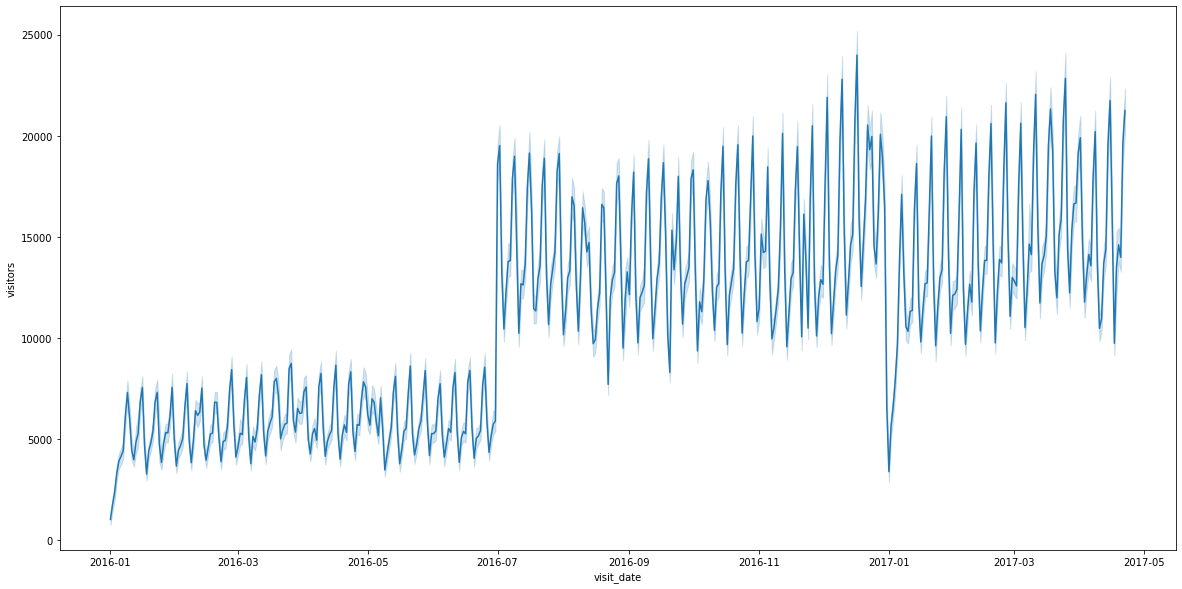

In [84]:
plt.figure(figsize=(20,10))
sns.lineplot(data = air_visit_df, x='visit_date', y='visitors', estimator=sum)
plt.show()

##### 알 수 있는 것
* 2016년 7월을 기점으로 방문자가 급격히 늘어났다.
* 일정한 기간을 기준으로 동일한 패턴이 반복된다.
* 2017년 1월은 어떤 이유인지 방문자가 줄어들었다.

#### 요일별

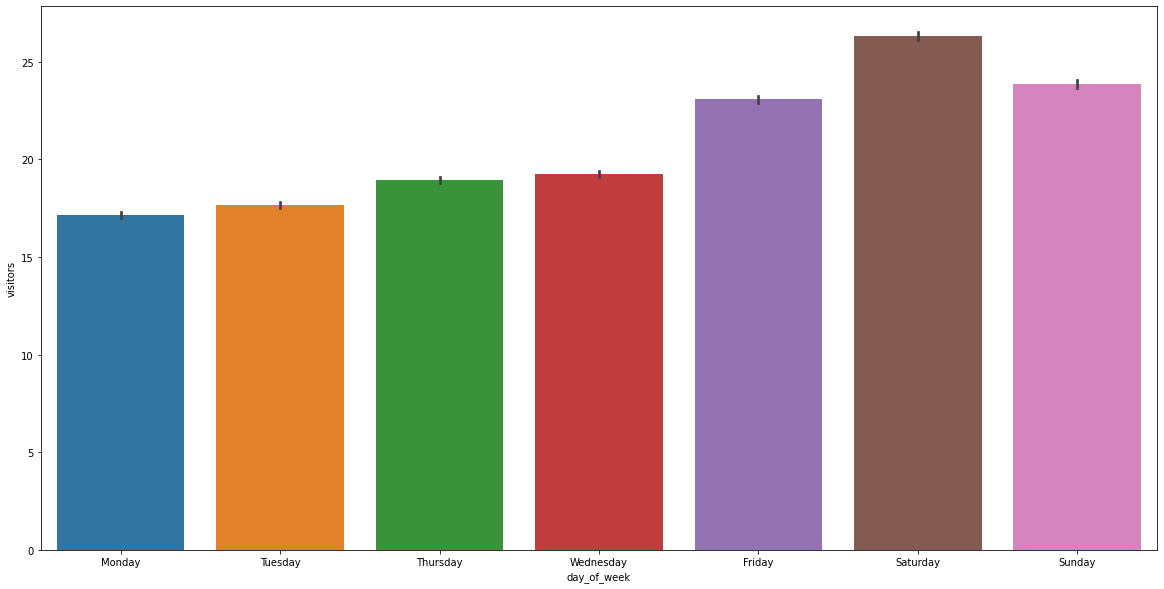

In [85]:
m = ['Monday', 'Tuesday', 'Thursday', 'Wednesday','Friday', 'Saturday', 'Sunday']
plt.figure(figsize=(20,10))
sns.barplot(data = air_visit_df, x='day_of_week', y='visitors', order=m)
plt.show()

##### 알 수 있는 것
* 월요일이 방문자가 제일 적다.
* 방문자가 월요일부터 토요일까지 증가했다가 일요일에 감소한다.

#### 월별

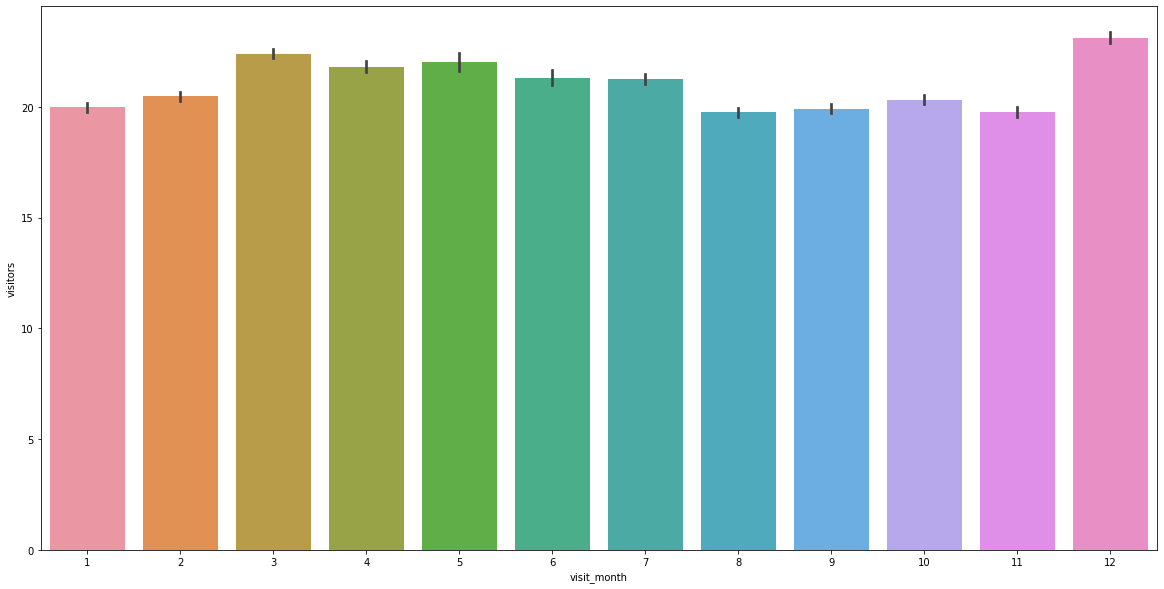

In [86]:
plt.figure(figsize=(20,10))
sns.barplot(data = air_visit_df, x='visit_month', y='visitors')
plt.show()

##### 알 수 있는 것
* 12월이 방문자가 제일 많다.
* 3~7월은 방문자가 높다.

#### 전체 기간동안 방문자와 예약자 추이

In [87]:
air_reserve_df = split_date_time(air_reserve)
air_reserve_df

,air_store_id,visit_datetime,reserve_datetime,reserve_visitors,visit_date,visit_time,reserve_date,reserve_time,calendar_date_x,day_of_week_x,holiday_flg_x,visit_year,visit_month,visit_day,calendar_date_y,day_of_week_y,holiday_flg_y,reserve_year,reserve_month,reserve_day
0,air_877f79706adbfb06,2016-01-01 19:00:00,2016-01-01 16:00:00,1,2016-01-01,19:00:00,2016-01-01,16:00:00,2016-01-01,Friday,1,2016,1,1,2016-01-01,Friday,1,2016,1,1
1,air_db4b38ebe7a7ceff,2016-01-01 19:00:00,2016-01-01 19:00:00,3,2016-01-01,19:00:00,2016-01-01,19:00:00,2016-01-01,Friday,1,2016,1,1,2016-01-01,Friday,1,2016,1,1
2,air_db4b38ebe7a7ceff,2016-01-01 19:00:00,2016-01-01 19:00:00,6,2016-01-01,19:00:00,2016-01-01,19:00:00,2016-01-01,Friday,1,2016,1,1,2016-01-01,Friday,1,2016,1,1
3,air_877f79706adbfb06,2016-01-01 20:00:00,2016-01-01 16:00:00,2,2016-01-01,20:00:00,2016-01-01,16:00:00,2016-01-01,Friday,1,2016,1,1,2016-01-01,Friday,1,2016,1,1
4,air_db80363d35f10926,2016-01-01 20:00:00,2016-01-01 01:00:00,5,2016-01-01,20:00:00,2016-01-01,01:00:00,2016-01-01,Friday,1,2016,1,1,2016-01-01,Friday,1,2016,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92373,air_683371d9baabf410,2017-05-23 12:00:00,2017-04-22 11:00:00,5,2017-05-23,12:00:00,2017-04-22,11:00:00,2017-05-23,Tuesday,0,2017,5,23,2017-04-22,Saturday,0,2017,4,22
92374,air_df554c4527a1cfe6,2017-05-27 19:00:00,2017-04-22 20:00:00,6,2017-05-27,19:00:00,2017-04-22,20:00:00,2017-05-27,Saturday,0,2017,5,27,2017-04-22,Saturday,0,2017,4,22
92375,air_683371d9baabf410,2017-05-28 11:00:00,2017-04-22 11:00:00,6,2017-05-28,11:00:00,2017-04-22,11:00:00,2017-05-28,Sunday,0,2017,5,28,2017-04-22,Saturday,0,2017,4,22
92376,air_f911308e19d64236,2017-05-28 12:00:00,2017-04-22 15:00:00,6,2017-05-28,12:00:00,2017-04-22,15:00:00,2017-05-28,Sunday,0,2017,5,28,2017-04-22,Saturday,0,2017,4,22


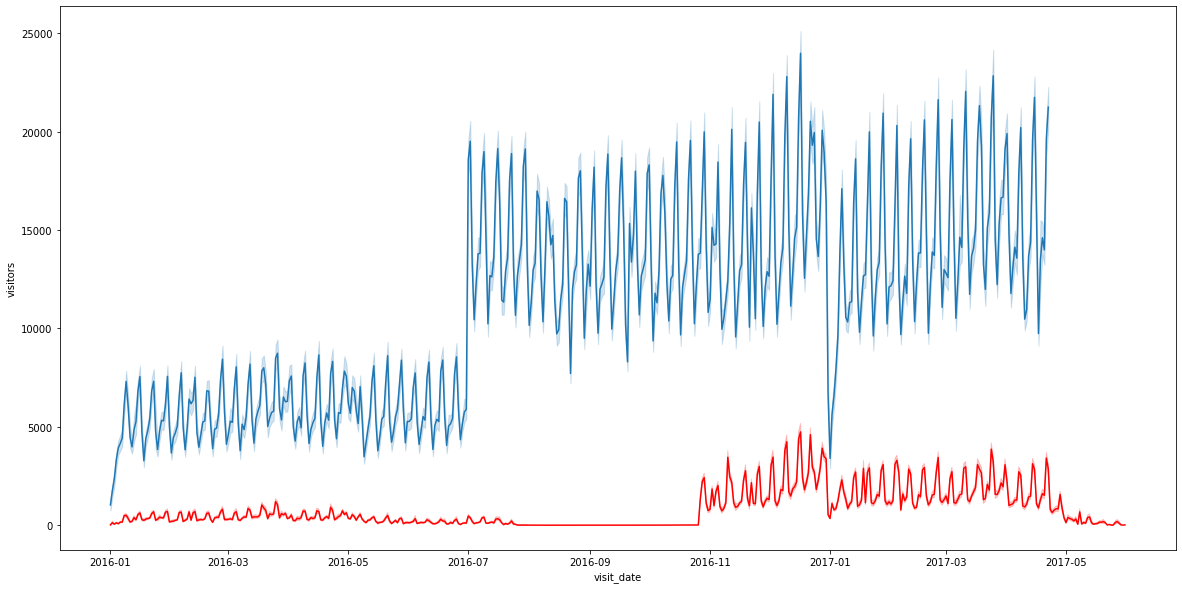

In [88]:
plt.figure(figsize=(20,10))
sns.lineplot(data = air_visit_df, x='visit_date', y='visitors', estimator=sum)
sns.lineplot(data = air_reserve_df, x='visit_date', y='reserve_visitors', color='r', estimator=sum)
plt.show()

##### 알 수 있는 것
* 2016년 7월부터 11월 전까지 방문 예약자수가 없다.
* 2017년 4월 말부터 방문자 데이터가 없는 것은 우리가 예측해야 하는 것이기 때문이다.

### 2016년도 추이 확인

#### 예약자 수

##### air

In [89]:
air_reserve_df = split_date_time(air_reserve)
air_reserve_df.head()

,air_store_id,visit_datetime,reserve_datetime,reserve_visitors,visit_date,visit_time,reserve_date,reserve_time,calendar_date_x,day_of_week_x,holiday_flg_x,visit_year,visit_month,visit_day,calendar_date_y,day_of_week_y,holiday_flg_y,reserve_year,reserve_month,reserve_day
0,air_877f79706adbfb06,2016-01-01 19:00:00,2016-01-01 16:00:00,1,2016-01-01,19:00:00,2016-01-01,16:00:00,2016-01-01,Friday,1,2016,1,1,2016-01-01,Friday,1,2016,1,1
1,air_db4b38ebe7a7ceff,2016-01-01 19:00:00,2016-01-01 19:00:00,3,2016-01-01,19:00:00,2016-01-01,19:00:00,2016-01-01,Friday,1,2016,1,1,2016-01-01,Friday,1,2016,1,1
2,air_db4b38ebe7a7ceff,2016-01-01 19:00:00,2016-01-01 19:00:00,6,2016-01-01,19:00:00,2016-01-01,19:00:00,2016-01-01,Friday,1,2016,1,1,2016-01-01,Friday,1,2016,1,1
3,air_877f79706adbfb06,2016-01-01 20:00:00,2016-01-01 16:00:00,2,2016-01-01,20:00:00,2016-01-01,16:00:00,2016-01-01,Friday,1,2016,1,1,2016-01-01,Friday,1,2016,1,1
4,air_db80363d35f10926,2016-01-01 20:00:00,2016-01-01 01:00:00,5,2016-01-01,20:00:00,2016-01-01,01:00:00,2016-01-01,Friday,1,2016,1,1,2016-01-01,Friday,1,2016,1,1


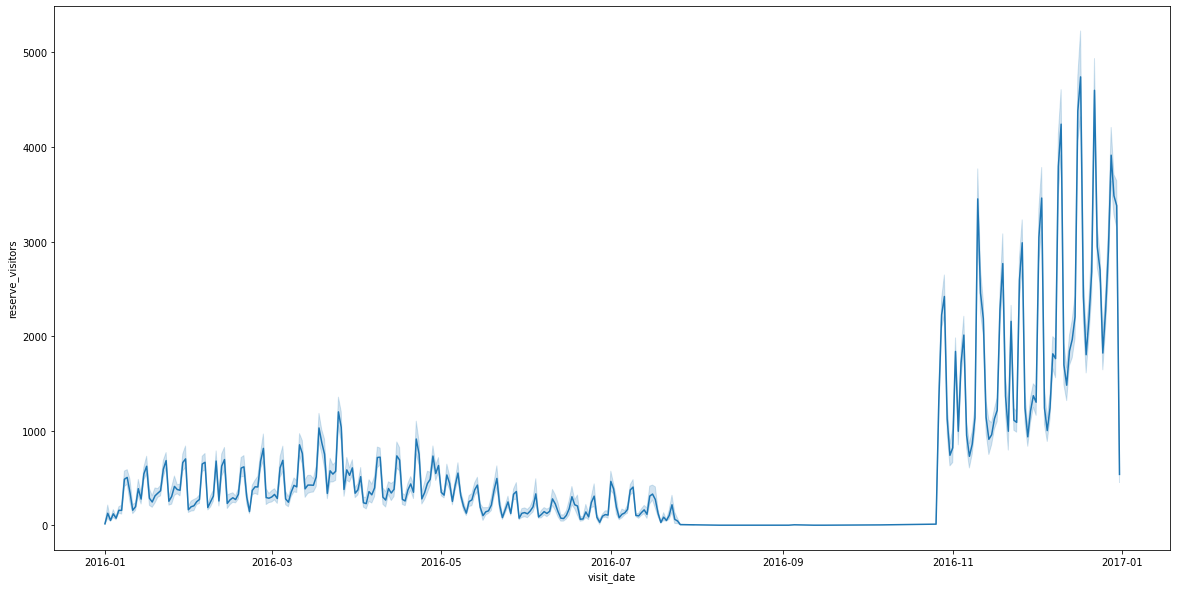

In [90]:
plt.figure(figsize=(20,10))
sns.lineplot(data = air_reserve_df[air_reserve_df.visit_year==2016], x='visit_date', y='reserve_visitors', estimator=sum)
plt.show()

##### 알 수 있는 것
* 2016년 10월 마지막주를 기점으로 방문 예약자가 급격히 늘어났다.
* 일정한 기간을 기준으로 동일한 패턴이 반복된다.
* 2017년 1월은 어떤 이유인지 방문 예약자가 줄어들었다.
* 2016년 8월즘부터 2016년 10월 마지막주까지 방문 예약자가 없다.

##### hpg

In [91]:
hpg_reserve_df = split_date_time(hpg_reserve)
hpg_reserve_df.head()

,hpg_store_id,visit_datetime,reserve_datetime,reserve_visitors,visit_date,visit_time,reserve_date,reserve_time,calendar_date_x,day_of_week_x,holiday_flg_x,visit_year,visit_month,visit_day,calendar_date_y,day_of_week_y,holiday_flg_y,reserve_year,reserve_month,reserve_day
0,hpg_c63f6f42e088e50f,2016-01-01 11:00:00,2016-01-01 09:00:00,1,2016-01-01,11:00:00,2016-01-01,09:00:00,2016-01-01,Friday,1,2016,1,1,2016-01-01,Friday,1,2016,1,1
1,hpg_dac72789163a3f47,2016-01-01 13:00:00,2016-01-01 06:00:00,3,2016-01-01,13:00:00,2016-01-01,06:00:00,2016-01-01,Friday,1,2016,1,1,2016-01-01,Friday,1,2016,1,1
2,hpg_c8e24dcf51ca1eb5,2016-01-01 16:00:00,2016-01-01 14:00:00,2,2016-01-01,16:00:00,2016-01-01,14:00:00,2016-01-01,Friday,1,2016,1,1,2016-01-01,Friday,1,2016,1,1
3,hpg_24bb207e5fd49d4a,2016-01-01 17:00:00,2016-01-01 11:00:00,5,2016-01-01,17:00:00,2016-01-01,11:00:00,2016-01-01,Friday,1,2016,1,1,2016-01-01,Friday,1,2016,1,1
4,hpg_25291c542ebb3bc2,2016-01-01 17:00:00,2016-01-01 03:00:00,13,2016-01-01,17:00:00,2016-01-01,03:00:00,2016-01-01,Friday,1,2016,1,1,2016-01-01,Friday,1,2016,1,1


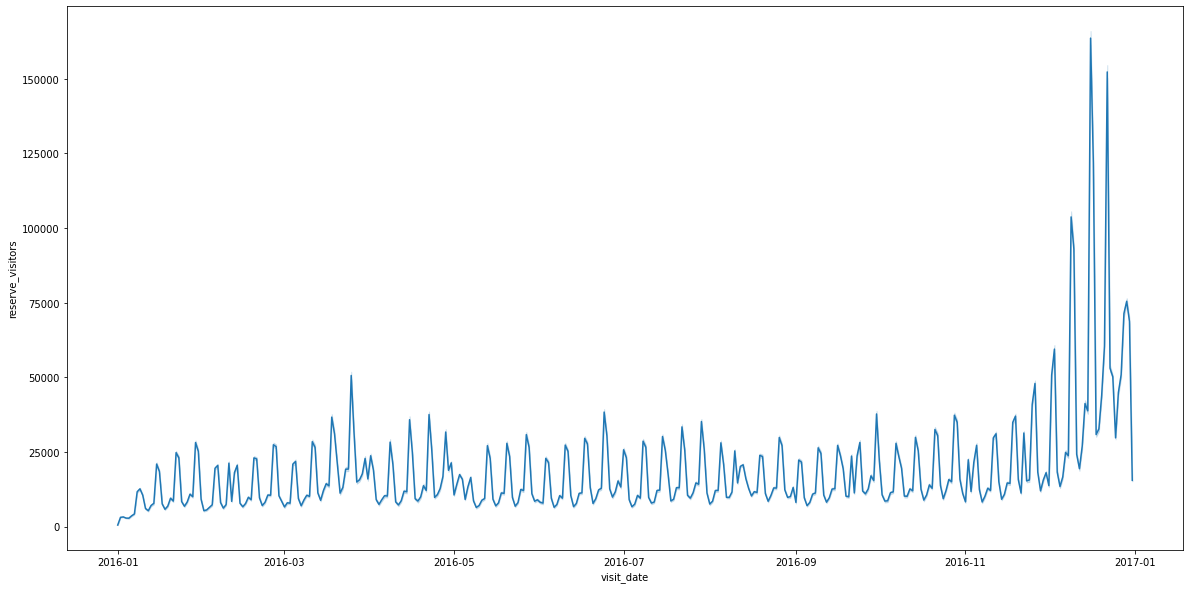

In [92]:
plt.figure(figsize=(20,10))
sns.lineplot(data = hpg_reserve_df[hpg_reserve_df.visit_year==2016], x='visit_date', y='reserve_visitors', estimator=sum)
plt.show()

##### 알 수 있는 것
* 2016년 연말에 상대적으로 방문 예약자가 많다.
* 전체적으로 계속 일정 패턴을 반복한다.

#### 방문자 수

In [93]:
air_visit_df = split_date_time(air_visit_data)
air_visit_df['visit_date'] = pd.to_datetime(air_visit_df['visit_date'])

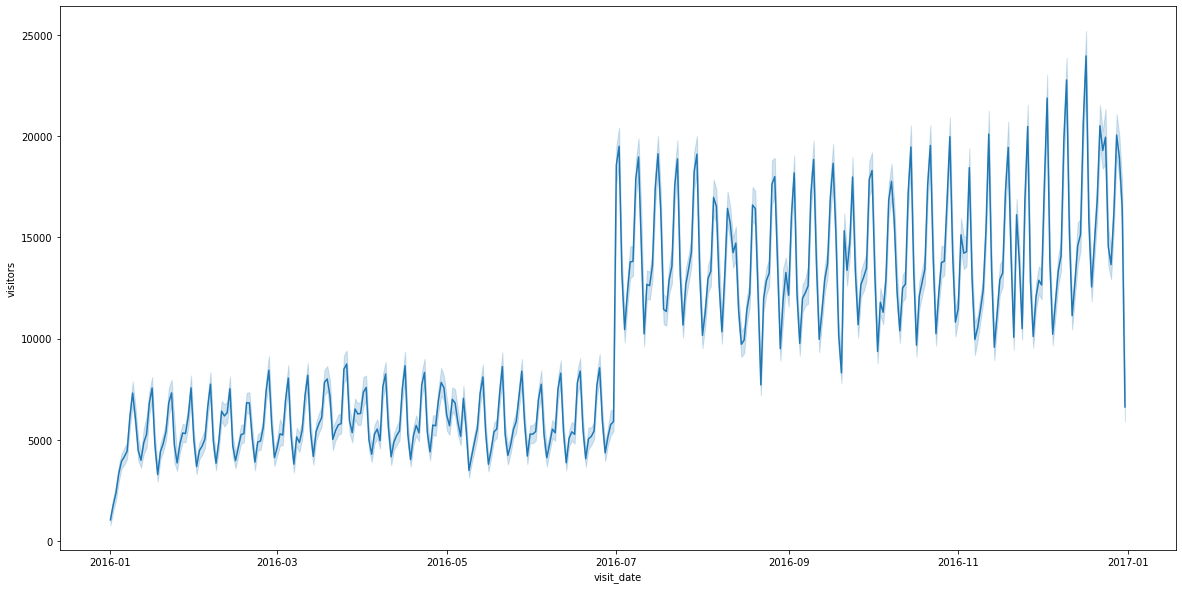

In [94]:
plt.figure(figsize=(20,10))
sns.lineplot(data = air_visit_df[air_visit_df.visit_year==2016], x='visit_date', y='visitors', estimator=sum)
plt.show()

##### 한달 기간 시각화

In [95]:
air_visit_df.loc[(air_visit_df['visit_year'] == 2016) & (air_visit_df['visit_month'] == 1)]

,air_store_id,visit_date,visitors,calendar_date,day_of_week,holiday_flg,visit_year,visit_month,visit_day
0,air_ba937bf13d40fb24,2016-01-13,25,2016-01-13,Wednesday,0,2016,1,13
1,air_25e9888d30b386df,2016-01-13,21,2016-01-13,Wednesday,0,2016,1,13
2,air_fd6aac1043520e83,2016-01-13,40,2016-01-13,Wednesday,0,2016,1,13
3,air_64d4491ad8cdb1c6,2016-01-13,5,2016-01-13,Wednesday,0,2016,1,13
4,air_ee3a01f0c71a769f,2016-01-13,18,2016-01-13,Wednesday,0,2016,1,13
...,...,...,...,...,...,...,...,...,...
252103,air_dfad598ff642dab7,2016-01-02,25,2016-01-02,Saturday,1,2016,1,2
252104,air_db4b38ebe7a7ceff,2016-01-02,9,2016-01-02,Saturday,1,2016,1,2
252105,air_232dcee6f7c51d37,2016-01-02,9,2016-01-02,Saturday,1,2016,1,2
252106,air_3b6438b125086430,2016-01-02,8,2016-01-02,Saturday,1,2016,1,2


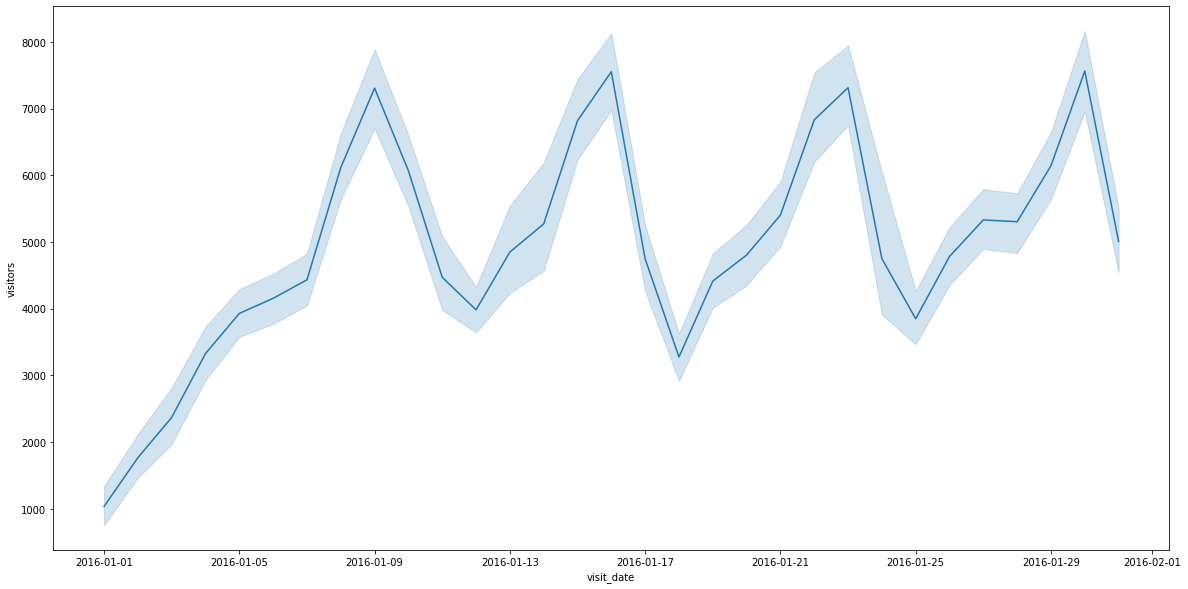

In [96]:
plt.figure(figsize=(20,10))
sns.lineplot(data = air_visit_df.loc[(air_visit_df['visit_year'] == 2016) & (air_visit_df['visit_month'] == 1)], x='visit_date', y='visitors', estimator=sum)
plt.show()

##### 1주 기간 시각화

In [97]:
air_visit_df['visit_week'] = air_visit_df['visit_date'].map(lambda x : x.isocalendar()[1])

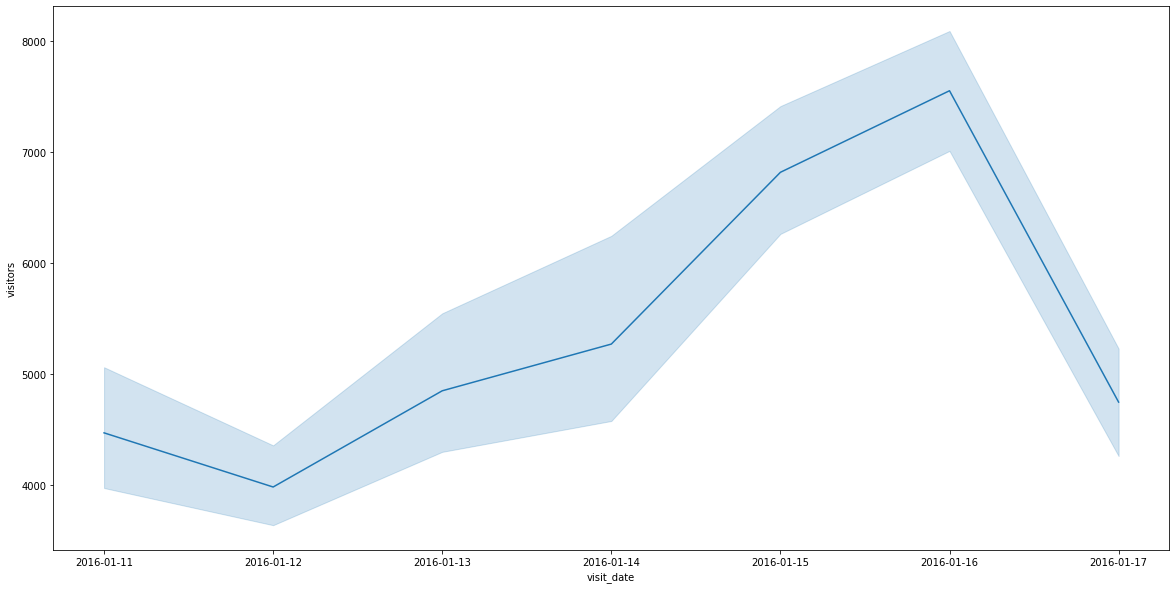

In [98]:
plt.figure(figsize=(20,10))
sns.lineplot(data = air_visit_df.loc[(air_visit_df['visit_year'] == 2016) & (air_visit_df['visit_month'] == 1) & (air_visit_df['visit_week'] == 2)], x='visit_date', y='visitors', estimator=sum)
plt.show()

##### 알 수 있는 것
* 월요일부터 점차 증가하다 토요일 정점을 찍고 다시 내려온다.

#### 2016년도 실제 방문자와 air+hgb 사이트의 예약자 비교

In [99]:
# 합치는 과정
air_reserve_df = split_date_time(air_reserve)

hpg_air_relation_df = pd.merge(hpg_reserve, store_id_relation, on='hpg_store_id')
hpg_air_relation_df = hpg_air_relation_df[['air_store_id', 'visit_datetime', 'reserve_datetime', 'reserve_visitors']]
hpg_air_relation_df = split_date_time(hpg_air_relation_df)
hpg_air_concat = pd.concat([air_reserve_df, hpg_air_relation_df])
hpg_air_concat.head()

,air_store_id,visit_datetime,reserve_datetime,reserve_visitors,visit_date,visit_time,reserve_date,reserve_time,calendar_date_x,day_of_week_x,holiday_flg_x,visit_year,visit_month,visit_day,calendar_date_y,day_of_week_y,holiday_flg_y,reserve_year,reserve_month,reserve_day
0,air_877f79706adbfb06,2016-01-01 19:00:00,2016-01-01 16:00:00,1,2016-01-01,19:00:00,2016-01-01,16:00:00,2016-01-01,Friday,1,2016,1,1,2016-01-01,Friday,1,2016,1,1
1,air_db4b38ebe7a7ceff,2016-01-01 19:00:00,2016-01-01 19:00:00,3,2016-01-01,19:00:00,2016-01-01,19:00:00,2016-01-01,Friday,1,2016,1,1,2016-01-01,Friday,1,2016,1,1
2,air_db4b38ebe7a7ceff,2016-01-01 19:00:00,2016-01-01 19:00:00,6,2016-01-01,19:00:00,2016-01-01,19:00:00,2016-01-01,Friday,1,2016,1,1,2016-01-01,Friday,1,2016,1,1
3,air_877f79706adbfb06,2016-01-01 20:00:00,2016-01-01 16:00:00,2,2016-01-01,20:00:00,2016-01-01,16:00:00,2016-01-01,Friday,1,2016,1,1,2016-01-01,Friday,1,2016,1,1
4,air_db80363d35f10926,2016-01-01 20:00:00,2016-01-01 01:00:00,5,2016-01-01,20:00:00,2016-01-01,01:00:00,2016-01-01,Friday,1,2016,1,1,2016-01-01,Friday,1,2016,1,1


In [100]:
air_visit_df = split_date_time(air_visit_data)

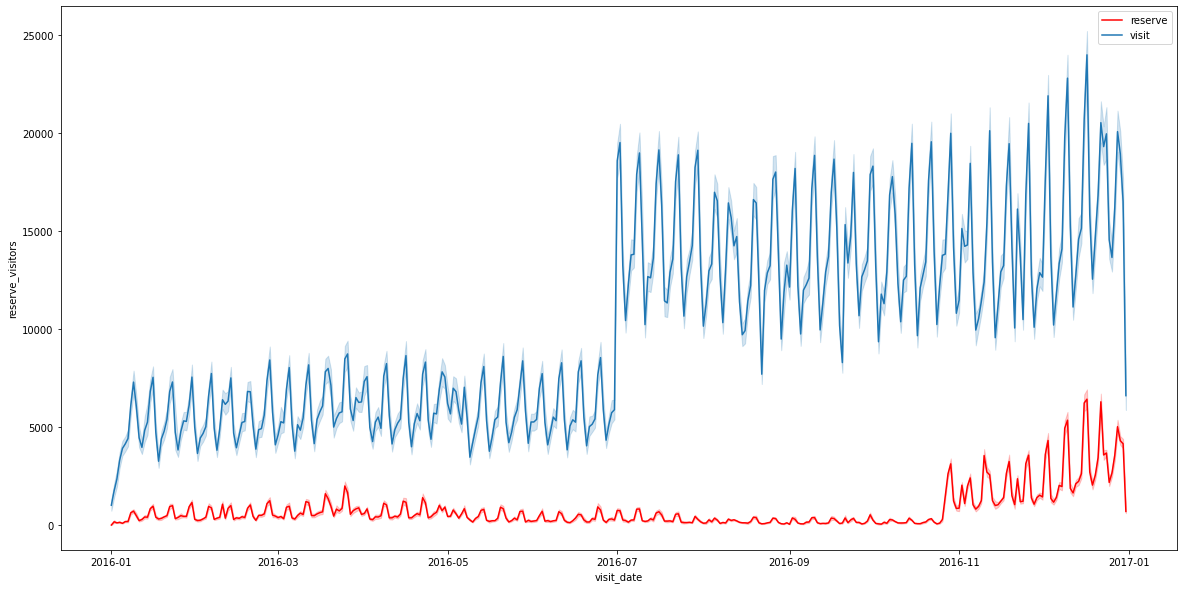

In [101]:
plt.figure(figsize=(20,10))
sns.lineplot(data = hpg_air_concat[hpg_air_concat.visit_year==2016], x='visit_date', y='reserve_visitors', estimator=sum, color='r')
sns.lineplot(data = air_visit_df[air_visit_df.visit_year==2016], x='visit_date', y='visitors', estimator=sum)
plt.legend(['reserve', 'visit'])
plt.show()

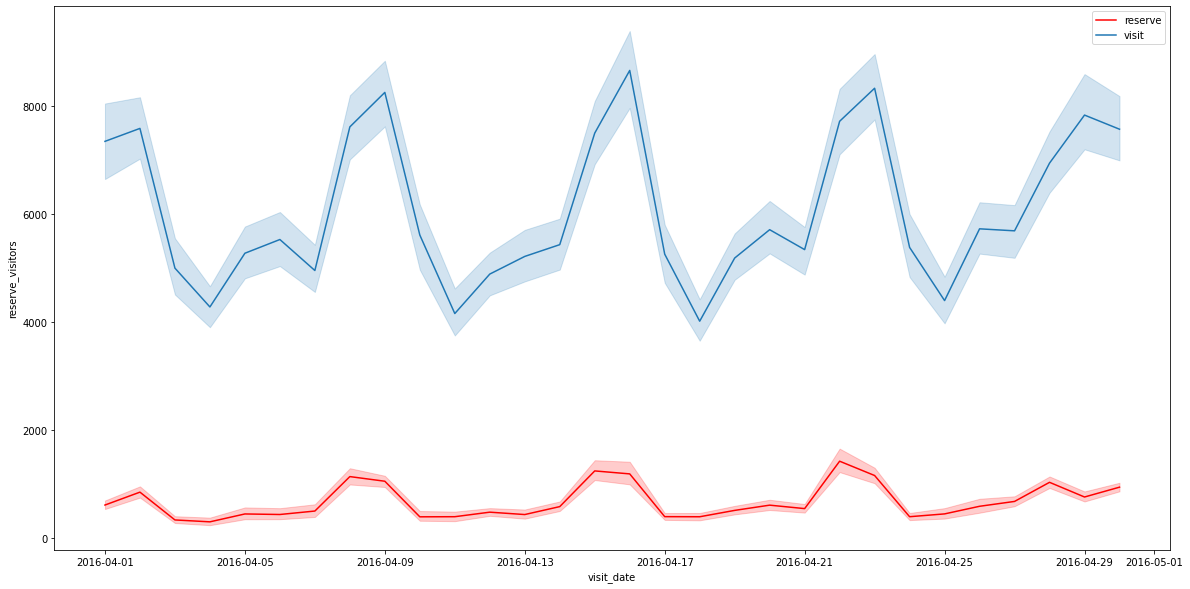

In [102]:
plt.figure(figsize=(20,10))
sns.lineplot(data = hpg_air_concat.loc[(hpg_air_concat['visit_year'] == 2016) & (hpg_air_concat['visit_month'] == 4)], x='visit_date', y='reserve_visitors', estimator=sum, color='r')
sns.lineplot(data = air_visit_df.loc[(air_visit_df['visit_year'] == 2016) & (air_visit_df['visit_month'] == 4)], x='visit_date', y='visitors', estimator=sum)
plt.legend(['reserve', 'visit'])
plt.show()

##### 알 수 있는 것
* 대채로 방문자가 많아지는 날에는 방문 예약자도 많다.

#### 2016년도 휴일과 예약율 간 관계 (air site에서)

##### 평균

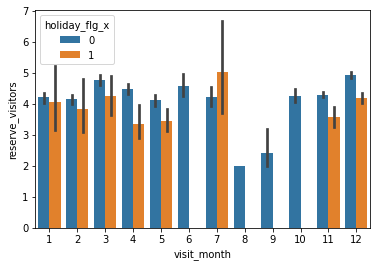

In [103]:
air_reserve_df = split_date_time(air_reserve)
sns.barplot(data=air_reserve_df.loc[(air_reserve_df.visit_year==2016)], x='visit_month', y='reserve_visitors',hue='holiday_flg_x')

##### 알 수 있는 것
* 3월과 7월, 12월이 평균 방문 예약자 수가 많다.(단체 예약자가 많다.)

##### 합계

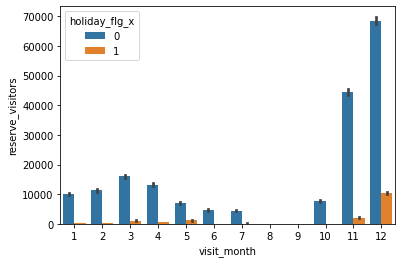

In [104]:
air_reserve_df = split_date_time(air_reserve)
sns.barplot(data=air_reserve_df.loc[(air_reserve_df.visit_year==2016)], x='visit_month', y='reserve_visitors',hue='holiday_flg_x', estimator=sum)

##### 알 수 있는 것
* 휴일 방문 예약자 수는 12월달이 월등히 높다.

#### 2016년도 휴일과 방문자 수 간 관계

##### 평균

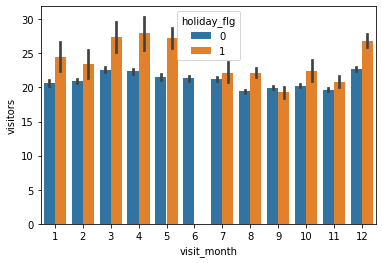

In [105]:
air_visit_df = split_date_time(air_visit_data)
sns.barplot(data=air_visit_df.loc[(air_visit_df.visit_year==2016)], x='visit_month', y='visitors',hue='holiday_flg')

##### 알 수 있는 것
* 3,4,5,12월달에 평균 방문자 수가 많다.(단체 손님이 많다.)

##### 합계

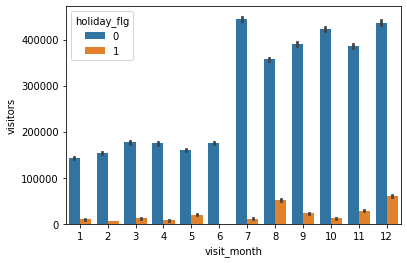

In [106]:
air_visit_df = split_date_time(air_visit_data)
sns.barplot(data=air_visit_df.loc[(air_visit_df.visit_year==2016)], x='visit_month', y='visitors',hue='holiday_flg', estimator=sum)

##### 알 수 있는 것
* 8월과 12월 휴일에 총 방문자 수가 많다.

#### 2016년도 golden week 기간의 추이

##### visit

In [107]:
air_visit_df = split_date_time(air_visit_data)

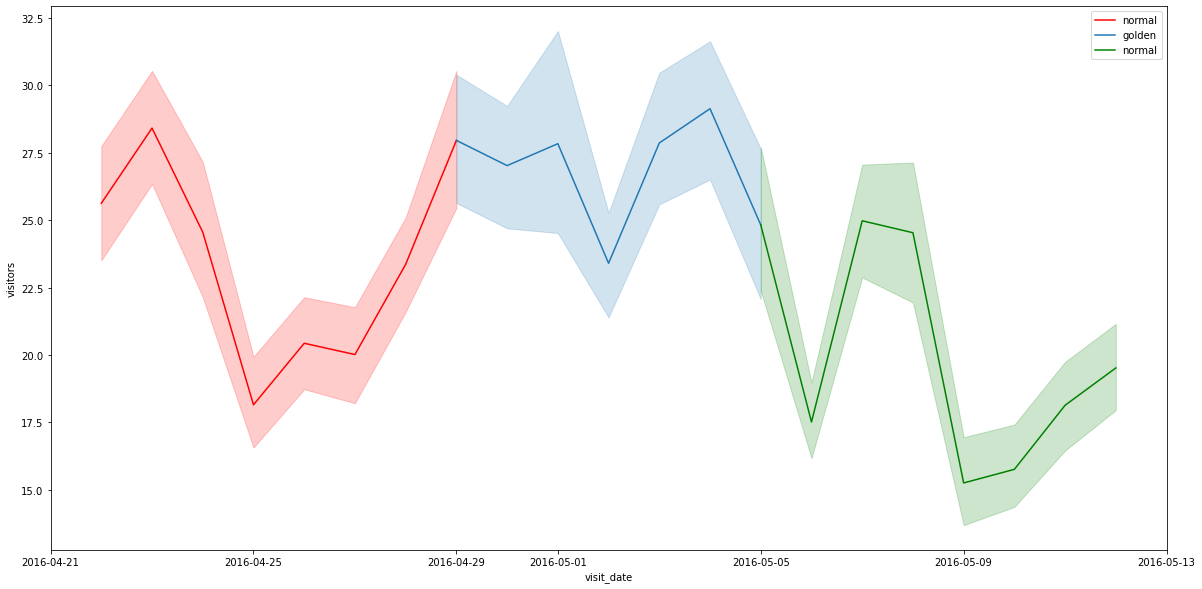

In [108]:
plt.figure(figsize=(20,10))
sns.lineplot(data = air_visit_df.loc[('2016-04-22'<=air_visit_df.visit_date) & (air_visit_df.visit_date<='2016-04-29')].sort_values(by=['visit_date']), x='visit_date', y='visitors', color='r')
sns.lineplot(data = air_visit_df.loc[('2016-04-29'<=air_visit_df.visit_date) & (air_visit_df.visit_date<='2016-05-05')].sort_values(by=['visit_date']), x='visit_date', y='visitors')
sns.lineplot(data = air_visit_df.loc[('2016-05-05'<=air_visit_df.visit_date) & (air_visit_df.visit_date<='2016-05-12')].sort_values(by=['visit_date']), x='visit_date', y='visitors', color='g')
plt.legend(['normal', 'golden','normal'])
plt.show()

##### 알 수 있는 것
* golden week에 방문자가 많다.
* golden week 이후에는 방문자가 적어진다.

##### reserve

In [109]:
air_reserve_df = split_date_time(air_reserve)

hpg_air_relation_df = pd.merge(hpg_reserve, store_id_relation, on='hpg_store_id')
hpg_air_relation_df = hpg_air_relation_df[['air_store_id', 'visit_datetime', 'reserve_datetime', 'reserve_visitors']]
hpg_air_relation_df = split_date_time(hpg_air_relation_df)
hpg_air_concat = pd.concat([air_reserve_df, hpg_air_relation_df])
hpg_air_concat.head()

,air_store_id,visit_datetime,reserve_datetime,reserve_visitors,visit_date,visit_time,reserve_date,reserve_time,calendar_date_x,day_of_week_x,holiday_flg_x,visit_year,visit_month,visit_day,calendar_date_y,day_of_week_y,holiday_flg_y,reserve_year,reserve_month,reserve_day
0,air_877f79706adbfb06,2016-01-01 19:00:00,2016-01-01 16:00:00,1,2016-01-01,19:00:00,2016-01-01,16:00:00,2016-01-01,Friday,1,2016,1,1,2016-01-01,Friday,1,2016,1,1
1,air_db4b38ebe7a7ceff,2016-01-01 19:00:00,2016-01-01 19:00:00,3,2016-01-01,19:00:00,2016-01-01,19:00:00,2016-01-01,Friday,1,2016,1,1,2016-01-01,Friday,1,2016,1,1
2,air_db4b38ebe7a7ceff,2016-01-01 19:00:00,2016-01-01 19:00:00,6,2016-01-01,19:00:00,2016-01-01,19:00:00,2016-01-01,Friday,1,2016,1,1,2016-01-01,Friday,1,2016,1,1
3,air_877f79706adbfb06,2016-01-01 20:00:00,2016-01-01 16:00:00,2,2016-01-01,20:00:00,2016-01-01,16:00:00,2016-01-01,Friday,1,2016,1,1,2016-01-01,Friday,1,2016,1,1
4,air_db80363d35f10926,2016-01-01 20:00:00,2016-01-01 01:00:00,5,2016-01-01,20:00:00,2016-01-01,01:00:00,2016-01-01,Friday,1,2016,1,1,2016-01-01,Friday,1,2016,1,1


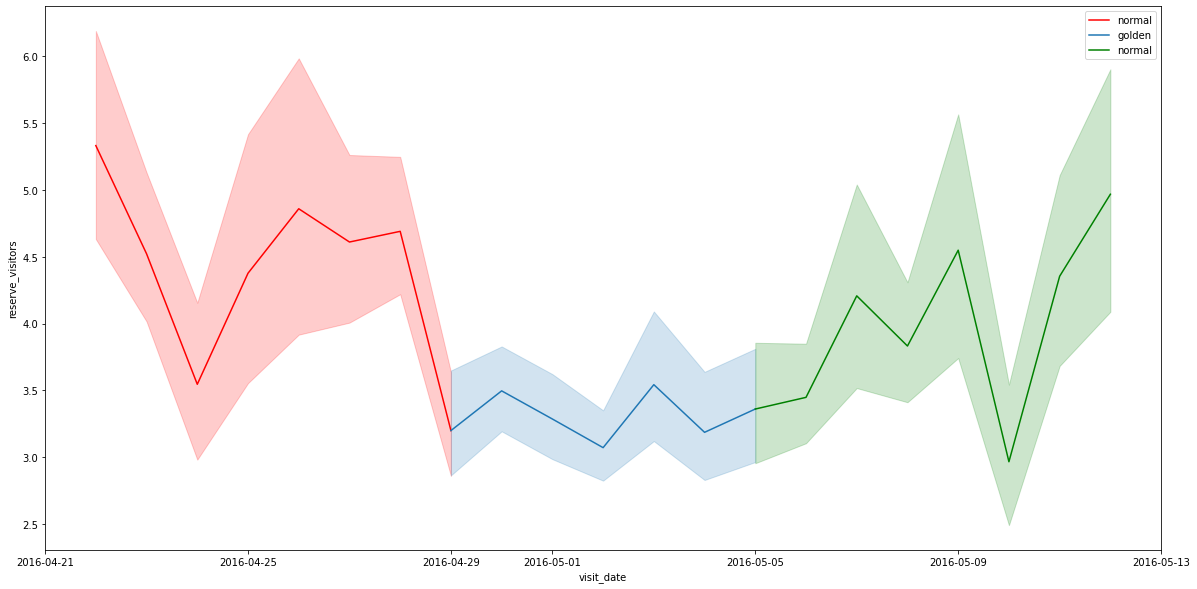

In [110]:
plt.figure(figsize=(20,10))
sns.lineplot(data = hpg_air_concat.loc[('2016-04-22'<=hpg_air_concat.visit_date) & (hpg_air_concat.visit_date<='2016-04-29')].sort_values(by=['visit_date']), x='visit_date', y='reserve_visitors', color='r')
sns.lineplot(data = hpg_air_concat.loc[('2016-04-29'<=hpg_air_concat.visit_date) & (hpg_air_concat.visit_date<='2016-05-05')].sort_values(by=['visit_date']), x='visit_date', y='reserve_visitors')
sns.lineplot(data = hpg_air_concat.loc[('2016-05-05'<=hpg_air_concat.visit_date) & (hpg_air_concat.visit_date<='2016-05-12')].sort_values(by=['visit_date']), x='visit_date', y='reserve_visitors', color='g')
plt.legend(['normal', 'golden','normal'])
plt.show()

##### 알 수 있는 것
* golden week에 예약자가 적다.
* visit 시각화 한것과 비교하면 예약하고 방문하는 사람보다 예약하지 않고 방문하는 사람이 많다.

### Air Reserve 정보 시각화

In [111]:
air_reserve_df = split_date_time(air_reserve)
air_reserve_info_df = pd.merge(air_reserve_df, air_store_info, on='air_store_id')
air_reserve_info_df.head()

,air_store_id,visit_datetime,reserve_datetime,reserve_visitors,visit_date,visit_time,reserve_date,reserve_time,calendar_date_x,day_of_week_x,holiday_flg_x,visit_year,visit_month,visit_day,calendar_date_y,day_of_week_y,holiday_flg_y,reserve_year,reserve_month,reserve_day,air_genre_name,air_area_name,latitude,longitude
0,air_877f79706adbfb06,2016-01-01 19:00:00,2016-01-01 16:00:00,1,2016-01-01,19:00:00,2016-01-01,16:00:00,2016-01-01,Friday,1,2016,1,1,2016-01-01,Friday,1,2016,1,1,Japanese food,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599
1,air_877f79706adbfb06,2016-01-01 20:00:00,2016-01-01 16:00:00,2,2016-01-01,20:00:00,2016-01-01,16:00:00,2016-01-01,Friday,1,2016,1,1,2016-01-01,Friday,1,2016,1,1,Japanese food,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599
2,air_877f79706adbfb06,2016-01-02 18:00:00,2016-01-01 16:00:00,2,2016-01-02,18:00:00,2016-01-01,16:00:00,2016-01-02,Saturday,1,2016,1,2,2016-01-01,Friday,1,2016,1,1,Japanese food,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599
3,air_877f79706adbfb06,2016-01-02 21:00:00,2016-01-01 16:00:00,2,2016-01-02,21:00:00,2016-01-01,16:00:00,2016-01-02,Saturday,1,2016,1,2,2016-01-01,Friday,1,2016,1,1,Japanese food,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599
4,air_877f79706adbfb06,2016-01-08 21:00:00,2016-01-04 20:00:00,2,2016-01-08,21:00:00,2016-01-04,20:00:00,2016-01-08,Friday,0,2016,1,8,2016-01-04,Monday,0,2016,1,4,Japanese food,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599


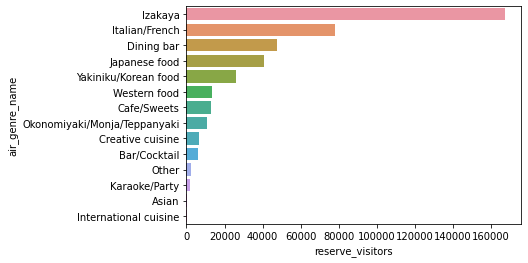

In [112]:
air_gnere_order = air_reserve_info_df.groupby(["air_genre_name"])['reserve_visitors'].sum().to_frame().sort_values(by='reserve_visitors', ascending=False)
sns.barplot(data=air_gnere_order, x='reserve_visitors', y = air_gnere_order.index)

### Hpg Reserve 정보 시각화

In [113]:
hpg_reserve_df = split_date_time(hpg_reserve)
hpg_reserve_info_df = pd.merge(hpg_reserve_df, hpg_store_info, on='hpg_store_id')
hpg_reserve_info_df.head()

,hpg_store_id,visit_datetime,reserve_datetime,reserve_visitors,visit_date,visit_time,reserve_date,reserve_time,calendar_date_x,day_of_week_x,holiday_flg_x,visit_year,visit_month,visit_day,calendar_date_y,day_of_week_y,holiday_flg_y,reserve_year,reserve_month,reserve_day,hpg_genre_name,hpg_area_name,latitude,longitude
0,hpg_dac72789163a3f47,2016-01-01 13:00:00,2016-01-01 06:00:00,3,2016-01-01,13:00:00,2016-01-01,06:00:00,2016-01-01,Friday,1,2016,1,1,2016-01-01,Friday,1,2016,1,1,French,Hyōgo-ken Kōbe-shi None,34.692109,135.191698
1,hpg_dac72789163a3f47,2016-01-02 12:00:00,2016-01-01 20:00:00,2,2016-01-02,12:00:00,2016-01-01,20:00:00,2016-01-02,Saturday,1,2016,1,2,2016-01-01,Friday,1,2016,1,1,French,Hyōgo-ken Kōbe-shi None,34.692109,135.191698
2,hpg_dac72789163a3f47,2016-01-03 19:00:00,2016-01-02 15:00:00,2,2016-01-03,19:00:00,2016-01-02,15:00:00,2016-01-03,Sunday,1,2016,1,3,2016-01-02,Saturday,1,2016,1,2,French,Hyōgo-ken Kōbe-shi None,34.692109,135.191698
3,hpg_dac72789163a3f47,2016-01-21 19:00:00,2016-01-03 00:00:00,2,2016-01-21,19:00:00,2016-01-03,00:00:00,2016-01-21,Thursday,0,2016,1,21,2016-01-03,Sunday,1,2016,1,3,French,Hyōgo-ken Kōbe-shi None,34.692109,135.191698
4,hpg_dac72789163a3f47,2016-01-10 17:00:00,2016-01-04 22:00:00,3,2016-01-10,17:00:00,2016-01-04,22:00:00,2016-01-10,Sunday,0,2016,1,10,2016-01-04,Monday,0,2016,1,4,French,Hyōgo-ken Kōbe-shi None,34.692109,135.191698


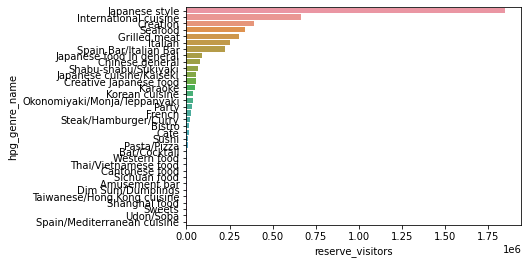

In [114]:
hpg_gnere_order = hpg_reserve_info_df.groupby(["hpg_genre_name"])['reserve_visitors'].sum().to_frame().sort_values(by='reserve_visitors', ascending=False)
sns.barplot(data=hpg_gnere_order, x='reserve_visitors', y = hpg_gnere_order.index)

상위 5개만 시각화

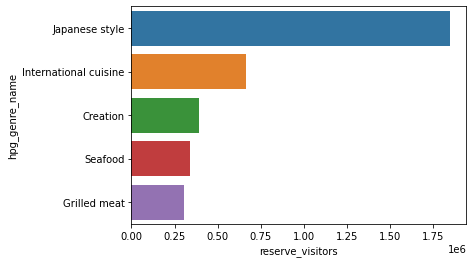

In [115]:
sns.barplot(data=hpg_gnere_order.iloc[:5], x='reserve_visitors', y = hpg_gnere_order.iloc[:5].index)

### Air Area Name 정보 시각화

In [116]:
air_reserve_df = split_date_time(air_reserve)
air_reserve_info_df = pd.merge(air_reserve_df, air_store_info, on='air_store_id')
air_reserve_info_df.head()

,air_store_id,visit_datetime,reserve_datetime,reserve_visitors,visit_date,visit_time,reserve_date,reserve_time,calendar_date_x,day_of_week_x,holiday_flg_x,visit_year,visit_month,visit_day,calendar_date_y,day_of_week_y,holiday_flg_y,reserve_year,reserve_month,reserve_day,air_genre_name,air_area_name,latitude,longitude
0,air_877f79706adbfb06,2016-01-01 19:00:00,2016-01-01 16:00:00,1,2016-01-01,19:00:00,2016-01-01,16:00:00,2016-01-01,Friday,1,2016,1,1,2016-01-01,Friday,1,2016,1,1,Japanese food,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599
1,air_877f79706adbfb06,2016-01-01 20:00:00,2016-01-01 16:00:00,2,2016-01-01,20:00:00,2016-01-01,16:00:00,2016-01-01,Friday,1,2016,1,1,2016-01-01,Friday,1,2016,1,1,Japanese food,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599
2,air_877f79706adbfb06,2016-01-02 18:00:00,2016-01-01 16:00:00,2,2016-01-02,18:00:00,2016-01-01,16:00:00,2016-01-02,Saturday,1,2016,1,2,2016-01-01,Friday,1,2016,1,1,Japanese food,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599
3,air_877f79706adbfb06,2016-01-02 21:00:00,2016-01-01 16:00:00,2,2016-01-02,21:00:00,2016-01-01,16:00:00,2016-01-02,Saturday,1,2016,1,2,2016-01-01,Friday,1,2016,1,1,Japanese food,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599
4,air_877f79706adbfb06,2016-01-08 21:00:00,2016-01-04 20:00:00,2,2016-01-08,21:00:00,2016-01-04,20:00:00,2016-01-08,Friday,0,2016,1,8,2016-01-04,Monday,0,2016,1,4,Japanese food,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599


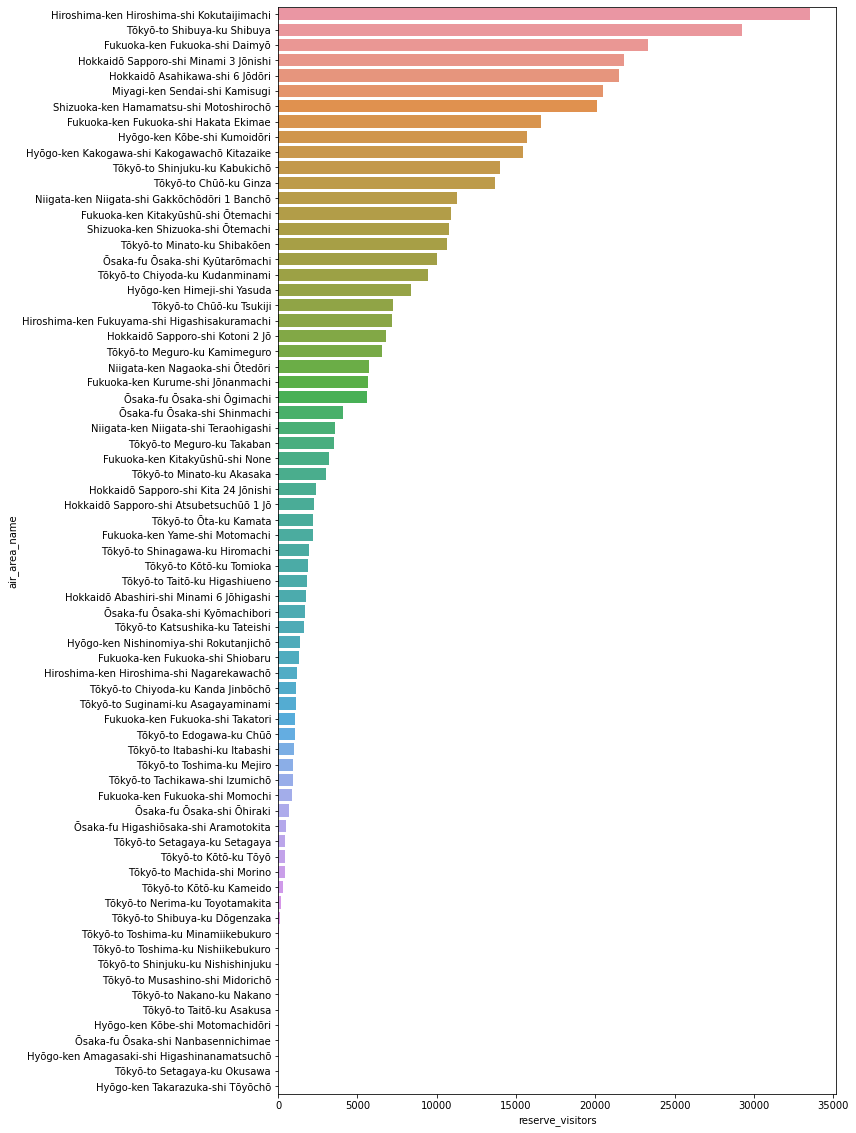

In [117]:
plt.figure(figsize=(10,20))
air_area_order = air_reserve_info_df.groupby(["air_area_name"])['reserve_visitors'].sum().to_frame().sort_values(by='reserve_visitors', ascending=False)
sns.barplot(data=air_area_order, x='reserve_visitors', y = air_area_order.index)

상위 5개만 시각화

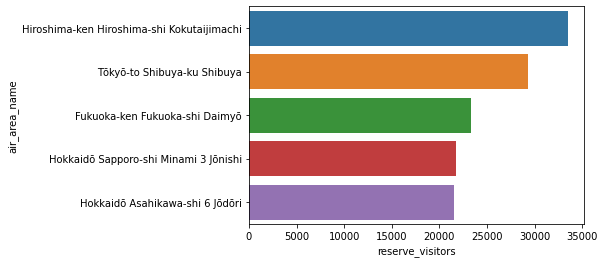

In [118]:
sns.barplot(data=air_area_order.iloc[:5], x='reserve_visitors', y = air_area_order.iloc[:5].index)

### Hpg Area Name 정보 시각화

In [119]:
hpg_reserve_df = split_date_time(hpg_reserve)
hpg_reserve_info_df = pd.merge(hpg_reserve_df, hpg_store_info, on='hpg_store_id')
hpg_reserve_info_df.head()

,hpg_store_id,visit_datetime,reserve_datetime,reserve_visitors,visit_date,visit_time,reserve_date,reserve_time,calendar_date_x,day_of_week_x,holiday_flg_x,visit_year,visit_month,visit_day,calendar_date_y,day_of_week_y,holiday_flg_y,reserve_year,reserve_month,reserve_day,hpg_genre_name,hpg_area_name,latitude,longitude
0,hpg_dac72789163a3f47,2016-01-01 13:00:00,2016-01-01 06:00:00,3,2016-01-01,13:00:00,2016-01-01,06:00:00,2016-01-01,Friday,1,2016,1,1,2016-01-01,Friday,1,2016,1,1,French,Hyōgo-ken Kōbe-shi None,34.692109,135.191698
1,hpg_dac72789163a3f47,2016-01-02 12:00:00,2016-01-01 20:00:00,2,2016-01-02,12:00:00,2016-01-01,20:00:00,2016-01-02,Saturday,1,2016,1,2,2016-01-01,Friday,1,2016,1,1,French,Hyōgo-ken Kōbe-shi None,34.692109,135.191698
2,hpg_dac72789163a3f47,2016-01-03 19:00:00,2016-01-02 15:00:00,2,2016-01-03,19:00:00,2016-01-02,15:00:00,2016-01-03,Sunday,1,2016,1,3,2016-01-02,Saturday,1,2016,1,2,French,Hyōgo-ken Kōbe-shi None,34.692109,135.191698
3,hpg_dac72789163a3f47,2016-01-21 19:00:00,2016-01-03 00:00:00,2,2016-01-21,19:00:00,2016-01-03,00:00:00,2016-01-21,Thursday,0,2016,1,21,2016-01-03,Sunday,1,2016,1,3,French,Hyōgo-ken Kōbe-shi None,34.692109,135.191698
4,hpg_dac72789163a3f47,2016-01-10 17:00:00,2016-01-04 22:00:00,3,2016-01-10,17:00:00,2016-01-04,22:00:00,2016-01-10,Sunday,0,2016,1,10,2016-01-04,Monday,0,2016,1,4,French,Hyōgo-ken Kōbe-shi None,34.692109,135.191698


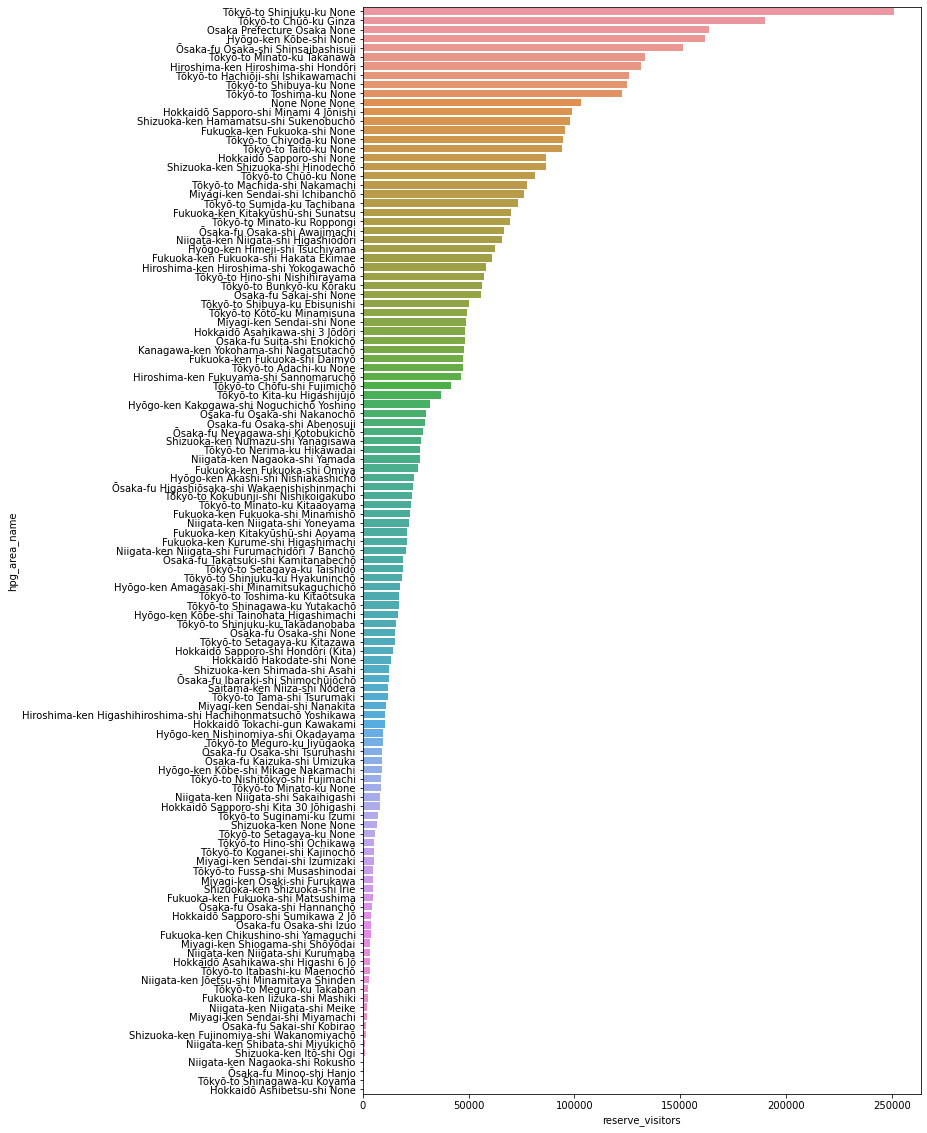

In [120]:
plt.figure(figsize=(10,20))
hpg_area_order = hpg_reserve_info_df.groupby(["hpg_area_name"])['reserve_visitors'].sum().to_frame().sort_values(by='reserve_visitors', ascending=False)
sns.barplot(data=hpg_area_order, x='reserve_visitors', y = hpg_area_order.index)

상위 5개만 시각화

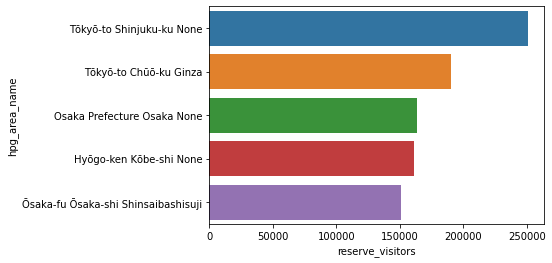

In [121]:
sns.barplot(data=hpg_area_order.iloc[:5], x='reserve_visitors', y = hpg_area_order.iloc[:5].index)

### Map을 통한 위치 시각화

In [122]:
import folium
from folium.plugins import MarkerCluster

df = area.loc[:, ['air_store_id', 'genre', 'latitude', 'longitude']]
df = df.drop_duplicates()
df.reset_index(inplace=True)

map = folium.Map([df['latitude'].mean(),df['longitude'].mean()],zoom_start=7)

list1=[]
list2=[]
marker_cluster = MarkerCluster().add_to(map)

for a in df.index:
    folium.Marker(location = [df.loc[a,"latitude"],df.loc[a,"longitude"]],
                  popup=df.loc[a,"air_store_id"]+'\n'+df.loc[a,"genre"]+'\n'+str(df.loc[a,"latitude"])+'\n'+str(df.loc[a,"longitude"])).add_to(marker_cluster)
    list1.append(df.loc[a,"latitude"])
    list2.append(df.loc[a,"longitude"])

map

#### 알 수 있는 것
* air로 예약한 여러 식당 타입 분포와 레스트랑의 위치적 분포를 보여준다.           
* 위도, 경도는 각 상점을 대표할 수 없다.(여러 상점이 같은 위도, 경도로 표시된다.)        

## Feature 찾기

In [123]:
# file load
file = area.copy()
target_name = 'visitors'
no_need_features = ['air_store_id', 'visit_date']
category_features = ['genre', 'area_name', 'day_of_week', 'holiday_flg']

In [124]:
# arrange X and y
file.drop(no_need_features, axis=1, inplace=True)
y_target = file[target_name]
X_features = file.drop([target_name],axis=1,inplace=False)

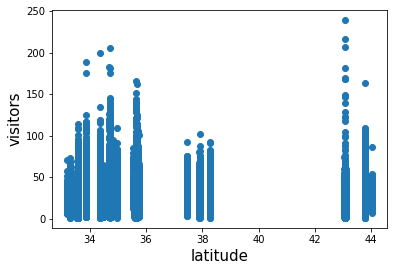

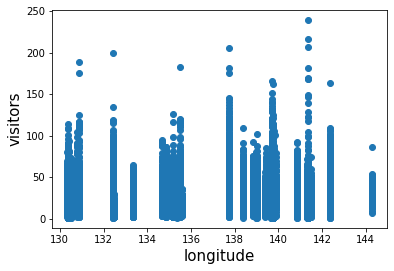

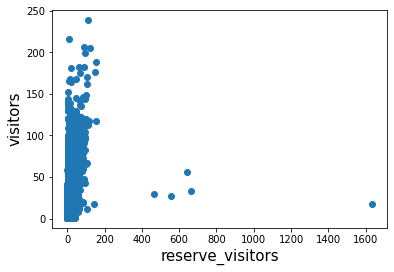

In [125]:

# visualize data to find outliers
for feature in X_features.drop(category_features, axis=1, inplace=False):
    plt.scatter(x = file[feature], y = y_target)
    plt.ylabel(target_name, fontsize=15)
    plt.xlabel(feature, fontsize=15)
    plt.show()

In [126]:
# remove outlier -> 예약자수가 400명 이상인 경우 제거
outlier_name = 'reserve_visitors'
cond1 = file[outlier_name] > 400
outlier_index = X_features[cond1].index
print('Outlier index :', outlier_index.values)
print('X_feature shape before Outlier is removed:', X_features.shape)
X_features.drop(outlier_index , axis=0, inplace=True)
y_target.drop(outlier_index, axis=0, inplace=True)
print('X_feature shape after Outlier is removed:', X_features.shape)

Outlier index : [ 2601  2602  2603  2604 12225]
X_feature shape before Outlier is removed: (28064, 7)
X_feature shape after Outlier is removed: (28059, 7)


In [127]:
from scipy.stats import skew

# 피처의 왜곡정도 파악 -> 1 이상이면 정규화 (하지만 여기서는 위도 경도 모두 정규화)
non_category_features_index = X_features.drop(category_features, axis=1, inplace=False).dtypes.index
skew_features = X_features[non_category_features_index].apply(lambda x : skew(x))
print(skew_features.sort_values(ascending=False))

skew_features_need_change = skew_features
X_features[skew_features_need_change.index] = np.log1p(X_features[skew_features_need_change.index])
X_features

reserve_visitors    2.075505
latitude            1.785027
longitude          -0.586010
dtype: float64


,genre,area_name,latitude,longitude,reserve_visitors,day_of_week,holiday_flg
0,Dining bar,Musashino-shi,3.603261,4.945679,2.564949,Saturday,0
1,Cafe/Sweets,Hamamatsu-shi,3.575456,4.932500,1.098612,Monday,0
2,Cafe/Sweets,Hamamatsu-shi,3.575456,4.932500,1.386294,Friday,0
3,Cafe/Sweets,Hamamatsu-shi,3.575456,4.932500,3.258097,Saturday,0
4,Cafe/Sweets,Hamamatsu-shi,3.575456,4.932500,1.791759,Sunday,0
...,...,...,...,...,...,...,...
28059,Izakaya,Niigata-shi,3.660331,4.941442,1.098612,Friday,0
28060,Izakaya,Niigata-shi,3.660331,4.941442,3.044522,Saturday,0
28061,Izakaya,Niigata-shi,3.660331,4.941442,1.945910,Wednesday,0
28062,Izakaya,Niigata-shi,3.660331,4.941442,3.367296,Saturday,0


In [128]:
# y 값도 정규화
y_target_log = np.log1p(y_target)
# print(y_target)
# print(y_target_log)

In [129]:
# sample_submission 데이터 전처리 -> one-hot encoding 시 같은 카테고리로 만들기 위해

# store_id, date 생성
# sample_submission_df.head()
temp = sample_submission.copy()
temp['store_id'] = temp['id'].str.slice(start=0, stop=20)
temp['date'] = temp['id'].str.slice(start=21, stop=31)
temp = temp.drop(['visitors'], axis='columns')
temp

,id,store_id,date
0,air_00a91d42b08b08d9_2017-04-23,air_00a91d42b08b08d9,2017-04-23
1,air_00a91d42b08b08d9_2017-04-24,air_00a91d42b08b08d9,2017-04-24
2,air_00a91d42b08b08d9_2017-04-25,air_00a91d42b08b08d9,2017-04-25
3,air_00a91d42b08b08d9_2017-04-26,air_00a91d42b08b08d9,2017-04-26
4,air_00a91d42b08b08d9_2017-04-27,air_00a91d42b08b08d9,2017-04-27
...,...,...,...
32014,air_fff68b929994bfbd_2017-05-27,air_fff68b929994bfbd,2017-05-27
32015,air_fff68b929994bfbd_2017-05-28,air_fff68b929994bfbd,2017-05-28
32016,air_fff68b929994bfbd_2017-05-29,air_fff68b929994bfbd,2017-05-29
32017,air_fff68b929994bfbd_2017-05-30,air_fff68b929994bfbd,2017-05-30


In [130]:
# 요일, 휴일 추가
temp2 = pd.merge(temp, date_info, left_on='date', right_on='calendar_date')
temp2 = temp2.drop(['date', 'calendar_date'], axis='columns')
temp2

,id,store_id,day_of_week,holiday_flg
0,air_00a91d42b08b08d9_2017-04-23,air_00a91d42b08b08d9,Sunday,0
1,air_0164b9927d20bcc3_2017-04-23,air_0164b9927d20bcc3,Sunday,0
2,air_0241aa3964b7f861_2017-04-23,air_0241aa3964b7f861,Sunday,0
3,air_0328696196e46f18_2017-04-23,air_0328696196e46f18,Sunday,0
4,air_034a3d5b40d5b1b1_2017-04-23,air_034a3d5b40d5b1b1,Sunday,0
...,...,...,...,...
32014,air_fea5dc9594450608_2017-05-31,air_fea5dc9594450608,Wednesday,0
32015,air_fee8dcf4d619598e_2017-05-31,air_fee8dcf4d619598e,Wednesday,0
32016,air_fef9ccb3ba0da2f7_2017-05-31,air_fef9ccb3ba0da2f7,Wednesday,0
32017,air_ffcc2d5087e1b476_2017-05-31,air_ffcc2d5087e1b476,Wednesday,0


In [131]:

# 장르, 지역, 위도, 경도 추가
temp3 = pd.merge(temp2, air_store_info, left_on='store_id', right_on='air_store_id')
temp3 = temp3.drop(['air_store_id', 'store_id'], axis='columns')
temp3 = temp3.rename(columns = {"air_genre_name":"genre", "air_area_name": "area_name"}, inplace = False)
temp3['genre'] = temp3['genre'].replace('Asian', 'Other')
temp3['genre'] = temp3['genre'].replace('International cuisine', 'Other')
temp3['area_name'] = temp3['area_name'].str.split(' ').str[0]
temp3 = temp3.sort_values(by=['id'], axis=0)
temp3

,id,day_of_week,holiday_flg,genre,area_name,latitude,longitude
0,air_00a91d42b08b08d9_2017-04-23,Sunday,0,Italian/French,Tōkyō-to,35.694003,139.753595
1,air_00a91d42b08b08d9_2017-04-24,Monday,0,Italian/French,Tōkyō-to,35.694003,139.753595
2,air_00a91d42b08b08d9_2017-04-25,Tuesday,0,Italian/French,Tōkyō-to,35.694003,139.753595
3,air_00a91d42b08b08d9_2017-04-26,Wednesday,0,Italian/French,Tōkyō-to,35.694003,139.753595
4,air_00a91d42b08b08d9_2017-04-27,Thursday,0,Italian/French,Tōkyō-to,35.694003,139.753595
...,...,...,...,...,...,...,...
32014,air_fff68b929994bfbd_2017-05-27,Saturday,0,Bar/Cocktail,Tōkyō-to,35.708146,139.666288
32015,air_fff68b929994bfbd_2017-05-28,Sunday,0,Bar/Cocktail,Tōkyō-to,35.708146,139.666288
32016,air_fff68b929994bfbd_2017-05-29,Monday,0,Bar/Cocktail,Tōkyō-to,35.708146,139.666288
32017,air_fff68b929994bfbd_2017-05-30,Tuesday,0,Bar/Cocktail,Tōkyō-to,35.708146,139.666288


In [132]:
# test file 값 정규화
non_category_features_index = temp3.drop(category_features+['id'], axis=1, inplace=False).dtypes.index
skew_features = temp3[non_category_features_index].apply(lambda x : skew(x))
print(skew_features.sort_values(ascending=False))
skew_features_need_change = skew_features
temp3[skew_features_need_change.index] = np.log1p(temp3[skew_features_need_change.index])
temp3

latitude     2.684234
longitude   -0.934611
dtype: float64


,id,day_of_week,holiday_flg,genre,area_name,latitude,longitude
0,air_00a91d42b08b08d9_2017-04-23,Sunday,0,Italian/French,Tōkyō-to,3.602613,4.947011
1,air_00a91d42b08b08d9_2017-04-24,Monday,0,Italian/French,Tōkyō-to,3.602613,4.947011
2,air_00a91d42b08b08d9_2017-04-25,Tuesday,0,Italian/French,Tōkyō-to,3.602613,4.947011
3,air_00a91d42b08b08d9_2017-04-26,Wednesday,0,Italian/French,Tōkyō-to,3.602613,4.947011
4,air_00a91d42b08b08d9_2017-04-27,Thursday,0,Italian/French,Tōkyō-to,3.602613,4.947011
...,...,...,...,...,...,...,...
32014,air_fff68b929994bfbd_2017-05-27,Saturday,0,Bar/Cocktail,Tōkyō-to,3.602999,4.946390
32015,air_fff68b929994bfbd_2017-05-28,Sunday,0,Bar/Cocktail,Tōkyō-to,3.602999,4.946390
32016,air_fff68b929994bfbd_2017-05-29,Monday,0,Bar/Cocktail,Tōkyō-to,3.602999,4.946390
32017,air_fff68b929994bfbd_2017-05-30,Tuesday,0,Bar/Cocktail,Tōkyō-to,3.602999,4.946390


In [133]:
# X_features와 submission file concat
frames = [X_features, temp3]
concated = pd.concat(frames, keys=['x','y'])
concated

genre  ...                               id
x 0        Dining bar  ...                              NaN
  1       Cafe/Sweets  ...                              NaN
  2       Cafe/Sweets  ...                              NaN
  3       Cafe/Sweets  ...                              NaN
  4       Cafe/Sweets  ...                              NaN
...               ...  ...                              ...
y 32014  Bar/Cocktail  ...  air_fff68b929994bfbd_2017-05-27
  32015  Bar/Cocktail  ...  air_fff68b929994bfbd_2017-05-28
  32016  Bar/Cocktail  ...  air_fff68b929994bfbd_2017-05-29
  32017  Bar/Cocktail  ...  air_fff68b929994bfbd_2017-05-30
  32018  Bar/Cocktail  ...  air_fff68b929994bfbd_2017-05-31

[60078 rows x 8 columns]

In [134]:
# 카테고리형 피쳐 one-hot encoding 후 train data와 제출용 data 분리
ohe = pd.get_dummies(concated, columns=category_features)
X_features_ohe = ohe.loc['x']

X_features_ohe = X_features_ohe.drop(['id'], axis='columns')
test_x = ohe.loc['y'].drop(['reserve_visitors'], axis='columns')
test_x = test_x.sort_values(by=['id'], axis=0)
# test_x_df

X_features_ohe

,latitude,longitude,reserve_visitors,genre_Bar/Cocktail,genre_Cafe/Sweets,genre_Creative cuisine,genre_Dining bar,genre_Italian/French,genre_Izakaya,genre_Japanese food,genre_Karaoke/Party,genre_Okonomiyaki/Monja/Teppanyaki,genre_Other,genre_Western food,genre_Yakiniku/Korean food,area_name_Abashiri-shi,area_name_Amagasaki-shi,area_name_Asahikawa-shi,area_name_Chiyoda-ku,area_name_Chūō-ku,area_name_Edogawa-ku,area_name_Fukuoka-ken,area_name_Fukuoka-shi,area_name_Fukuyama-shi,area_name_Hamamatsu-shi,area_name_Higashiōsaka-shi,area_name_Himeji-shi,area_name_Hiroshima-ken,area_name_Hiroshima-shi,area_name_Hokkaidō,area_name_Hyōgo-ken,area_name_Itabashi-ku,area_name_Kakogawa-shi,area_name_Katsushika-ku,area_name_Kitakyūshū-shi,area_name_Kurume-shi,area_name_Kōbe-shi,area_name_Kōtō-ku,area_name_Machida-shi,area_name_Meguro-ku,area_name_Minato-ku,area_name_Miyagi-ken,area_name_Musashino-shi,area_name_Nagaoka-shi,area_name_Nakano-ku,area_name_Nerima-ku,area_name_Niigata-ken,area_name_Niigata-shi,area_name_Nishinomiya-shi,area_name_Sapporo-shi,area_name_Sendai-shi,area_name_Setagaya-ku,area_name_Shibuya-ku,area_name_Shinagawa-ku,area_name_Shinjuku-ku,area_name_Shizuoka-ken,area_name_Shizuoka-shi,area_name_Suginami-ku,area_name_Tachikawa-shi,area_name_Taitō-ku,area_name_Takarazuka-shi,area_name_Toshima-ku,area_name_Tōkyō-to,area_name_Yame-shi,area_name_Ōsaka-fu,area_name_Ōsaka-shi,area_name_Ōta-ku,day_of_week_Friday,day_of_week_Monday,day_of_week_Saturday,day_of_week_Sunday,day_of_week_Thursday,day_of_week_Tuesday,day_of_week_Wednesday,holiday_flg_0,holiday_flg_1
0,3.603261,4.945679,2.564949,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
1,3.575456,4.932500,1.098612,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0
2,3.575456,4.932500,1.386294,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0
3,3.575456,4.932500,3.258097,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
4,3.575456,4.932500,1.791759,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28059,3.660331,4.941442,1.098612,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0
28060,3.660331,4.941442,3.044522,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
28061,3.660331,4.941442,1.945910,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0
28062,3.660331,4.941442,3.367296,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0


In [135]:
X_features_final = X_features_ohe.drop(['reserve_visitors'], axis='columns')
X_features_final

,latitude,longitude,genre_Bar/Cocktail,genre_Cafe/Sweets,genre_Creative cuisine,genre_Dining bar,genre_Italian/French,genre_Izakaya,genre_Japanese food,genre_Karaoke/Party,genre_Okonomiyaki/Monja/Teppanyaki,genre_Other,genre_Western food,genre_Yakiniku/Korean food,area_name_Abashiri-shi,area_name_Amagasaki-shi,area_name_Asahikawa-shi,area_name_Chiyoda-ku,area_name_Chūō-ku,area_name_Edogawa-ku,area_name_Fukuoka-ken,area_name_Fukuoka-shi,area_name_Fukuyama-shi,area_name_Hamamatsu-shi,area_name_Higashiōsaka-shi,area_name_Himeji-shi,area_name_Hiroshima-ken,area_name_Hiroshima-shi,area_name_Hokkaidō,area_name_Hyōgo-ken,area_name_Itabashi-ku,area_name_Kakogawa-shi,area_name_Katsushika-ku,area_name_Kitakyūshū-shi,area_name_Kurume-shi,area_name_Kōbe-shi,area_name_Kōtō-ku,area_name_Machida-shi,area_name_Meguro-ku,area_name_Minato-ku,area_name_Miyagi-ken,area_name_Musashino-shi,area_name_Nagaoka-shi,area_name_Nakano-ku,area_name_Nerima-ku,area_name_Niigata-ken,area_name_Niigata-shi,area_name_Nishinomiya-shi,area_name_Sapporo-shi,area_name_Sendai-shi,area_name_Setagaya-ku,area_name_Shibuya-ku,area_name_Shinagawa-ku,area_name_Shinjuku-ku,area_name_Shizuoka-ken,area_name_Shizuoka-shi,area_name_Suginami-ku,area_name_Tachikawa-shi,area_name_Taitō-ku,area_name_Takarazuka-shi,area_name_Toshima-ku,area_name_Tōkyō-to,area_name_Yame-shi,area_name_Ōsaka-fu,area_name_Ōsaka-shi,area_name_Ōta-ku,day_of_week_Friday,day_of_week_Monday,day_of_week_Saturday,day_of_week_Sunday,day_of_week_Thursday,day_of_week_Tuesday,day_of_week_Wednesday,holiday_flg_0,holiday_flg_1
0,3.603261,4.945679,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
1,3.575456,4.932500,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0
2,3.575456,4.932500,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0
3,3.575456,4.932500,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
4,3.575456,4.932500,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28059,3.660331,4.941442,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0
28060,3.660331,4.941442,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
28061,3.660331,4.941442,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0
28062,3.660331,4.941442,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0


## 모델 학습

In [398]:
test_x_df

# test data의 index를 id로 설정하여 순서가 바뀌지 않도록 함
test_x2_df = test_x_df.set_index('id',inplace = False)
test_x2_df

X_features_final

# model define
# model = Ridge(alpha=170)
# model.fit(x_temp_features, y_target)

# predict
# predict_value = model.predict(test_x2_df)
# print("**Single Model**")
# test_y = []
# for x in predict_value:
#     test_y.append(round(x,1))
# final_sub_df = sample_submission_df.copy()
# final_sub_df['visitors'] = test_y
# final_sub_df

# mixed model
model1 = LinearRegression()
model2 = GradientBoostingRegressor(learning_rate=0.02, n_estimators=500, subsample=0.05)
# model3 = xgb_reg = XGBRegressor(eta=0.1, min_child_weight=3, max_depth=3, n_estimators=120)

model1.fit(X_features_final, y_target)
model2.fit(X_features_final, y_target)
# model3.fit(X_features_final, y_target)

# mixed model
pred1 = model1.predict(test_x2_df)
pred2 = model2.predict(test_x2_df)
# pred3 = model3.predict(test_x2_df)

pred = 0.3 * pred2 + 0.7 * pred2
test_y2 = []
for x in pred:
    test_y2.append(round(x,3))

final_sub_df = sample_submission_df.copy()
final_sub_df['visitors'] = test_y2
final_sub_df# declare the model
lr_reg = LinearRegression()
ridge_reg = Ridge()
lasso_reg = Lasso()
en_reg = ElasticNet()
dt_reg = DecisionTreeRegressor()
rf_reg = RandomForestRegressor()
gbm_reg = GradientBoostingRegressor()
xgb_reg = XGBRegressor()
lgbm_reg = LGBMRegressor()

In [399]:
# 최적의 하이퍼 파라미터를 리턴
def get_best_params(model, params, X, y):
    grid_model = GridSearchCV(model, param_grid=params, scoring='neg_mean_squared_log_error', cv=5)
    grid_model.fit(X, y)
    rmsle = np.sqrt(-1* grid_model.best_score_)
    print('{0} 5 CV best average RMSLE value: {1}, best alpha:{2}'.format(model.__class__.__name__,np.round(rmsle, 4), grid_model.best_params_))
    return grid_model.best_estimator_

In [400]:
# find best parameters
# ridge_params = { 'alpha':[130, 150, 170]}
# lasso_params = { 'alpha':[0.003, 0.004, 0.005]}
# en_params = { 'alpha':[0.001, 0.005, 0.01, 0.05, 0.07, 0.1]}
# dt_params = {'max_depth':[1,2,3,4,5,6]}
#rf_params = {'n_estimators':[200], 'max_depth' : [5], 'min_samples_leaf' : [2], 'min_samples_split' : [5]}

# gbm_params = {'learning_rate': [0.01, 0.1, 0.5], 'n_estimators':[100, 500, 700], 'subsample': [0.01, 0.05, 0.1]}
# xgb_params = {'colsample_bytree': [1], 'eta': [0.1], 'max_depth': [3], 'min_child_weight': [3], 'n_estimators':[120]}

# best_rige = get_best_params(ridge_reg, ridge_params, X_features_ohe, y_target_log)
# best_lasso = get_best_params(lasso_reg, lasso_params, X_features_ohe, y_target_log)
# best_en = get_best_params(en_reg, en_params, X_features_ohe, y_target_log)
# best_dt = get_best_params(dt_reg, dt_params, X_features_ohe, y_target_log)
# best_rf = get_best_params(rf_reg, rf_params, X_features_ohe, y_target_log)

# best_gbm = get_best_params(gbm_reg, gbm_params, X_features_ohe, y_target_log)
# best_xgb = get_best_params(xgb_reg, xgb_params, X_features_ohe, y_target_log)

In [401]:
# define the model
lr_reg = LinearRegression()
ridge_reg = Ridge(alpha=170)
lasso_reg = Lasso(alpha=0.004)
en_reg = ElasticNet(alpha=0.01)
dt_reg = DecisionTreeRegressor(max_depth=4)
rf_reg = RandomForestRegressor(max_depth=5, min_samples_leaf=2, min_samples_split=5, n_estimators=200, n_jobs=-1)
gbm_reg = GradientBoostingRegressor(learning_rate=0.02, n_estimators=500, subsample=0.05)
xgb_reg = XGBRegressor(eta=0.1, min_child_weight=3, max_depth=3, n_estimators=120)
lgbm_reg = LGBMRegressor(learning_rate=0.03, max_depth=3, min_child_samples=10, n_estimators=1000, num_leaves=3)

In [402]:
# split train/test data
X_train, X_test, y_train, y_test = train_test_split(X_features_final, y_target_log, test_size=0.2, random_state=0)

In [403]:
def get_model_predict(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    # scale back by expm1() if the predicted result is predicted by log-translated data
    y_test = np.expm1(y_test)
    pred = np.expm1(pred)
    print('\n###',model.__class__.__name__,'###')
    evaluate_regr(y_test, pred)
    
# calculate MAE, MSE, RMSE, RMSLE
def evaluate_regr(y, pred):
    mae_val = mean_absolute_error(y, pred)
    mse_val = mean_squared_error(y, pred)
    rmse_val = rmse(y, pred)
    rmsle_val = rmsle(y,pred)
    r2_val = r2_score(y, pred)
    print('MAE: {0:.3F}, MSE: {1:.3F}, RMSE: {2:.3F}, RMSLE: {3:.3F}, R2: {4:.3F}'.format(mae_val, mse_val, rmse_val, rmsle_val, r2_val))

# calculate RMSLE using log1p(), not log() because of the NaN issue 
def rmsle(y, pred):
    log_y = np.log1p(y)
    log_pred = np.log1p(pred)
    squared_error = (log_y - log_pred) ** 2
    rmsle = np.sqrt(np.mean(squared_error))
    return rmsle

# calculate RMSE using mean_square_error() of Scikit-learn 
def rmse(y,pred):
    return np.sqrt(mean_squared_error(y,pred))

In [404]:
# linear regression models
models_linear = [lr_reg, ridge_reg, lasso_reg, en_reg]
for model in models_linear:
    get_model_predict(model,X_train, X_test, y_train, y_test)


### LinearRegression ###
MAE: 11.912, MSE: 281.274, RMSE: 16.771, RMSLE: 0.623, R2: 0.135

### Ridge ###
MAE: 12.053, MSE: 288.543, RMSE: 16.987, RMSLE: 0.629, R2: 0.112

### Lasso ###
MAE: 12.307, MSE: 299.711, RMSE: 17.312, RMSLE: 0.641, R2: 0.078

### ElasticNet ###
MAE: 12.399, MSE: 304.794, RMSE: 17.458, RMSLE: 0.646, R2: 0.062


In [405]:
# regression tree models
models_tree = [dt_reg, rf_reg, gbm_reg, xgb_reg]
# models_tree = [dt_reg]
for model in models_tree:
    get_model_predict(model,X_train, X_test, y_train, y_test)


### DecisionTreeRegressor ###
MAE: 12.430, MSE: 308.252, RMSE: 17.557, RMSLE: 0.650, R2: 0.052

### RandomForestRegressor ###
MAE: 12.214, MSE: 298.850, RMSE: 17.287, RMSLE: 0.638, R2: 0.081

### GradientBoostingRegressor ###
MAE: 11.258, MSE: 259.527, RMSE: 16.110, RMSLE: 0.590, R2: 0.202

### XGBRegressor ###
MAE: 11.464, MSE: 268.742, RMSE: 16.393, RMSLE: 0.600, R2: 0.173


##  모델 평가

In [406]:
test_x_df

,latitude,longitude,id,genre_Bar/Cocktail,genre_Cafe/Sweets,genre_Creative cuisine,genre_Dining bar,genre_Italian/French,genre_Izakaya,genre_Japanese food,...,area_name_Ōta-ku,day_of_week_Friday,day_of_week_Monday,day_of_week_Saturday,day_of_week_Sunday,day_of_week_Thursday,day_of_week_Tuesday,day_of_week_Wednesday,holiday_flg_0,holiday_flg_1
0,3.602613,4.947011,air_00a91d42b08b08d9_2017-04-23,0,0,0,0,1,0,0,...,0,0,0,0,1,0,0,0,1,0
1,3.602613,4.947011,air_00a91d42b08b08d9_2017-04-24,0,0,0,0,1,0,0,...,0,0,1,0,0,0,0,0,1,0
2,3.602613,4.947011,air_00a91d42b08b08d9_2017-04-25,0,0,0,0,1,0,0,...,0,0,0,0,0,0,1,0,1,0
3,3.602613,4.947011,air_00a91d42b08b08d9_2017-04-26,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,1,0
4,3.602613,4.947011,air_00a91d42b08b08d9_2017-04-27,0,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32014,3.602999,4.946390,air_fff68b929994bfbd_2017-05-27,1,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0
32015,3.602999,4.946390,air_fff68b929994bfbd_2017-05-28,1,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0
32016,3.602999,4.946390,air_fff68b929994bfbd_2017-05-29,1,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0
32017,3.602999,4.946390,air_fff68b929994bfbd_2017-05-30,1,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0


In [407]:
# test data의 index를 id로 설정하여 순서가 바뀌지 않도록 함
test_x2_df = test_x_df.set_index('id',inplace = False)
test_x2_df

,latitude,longitude,genre_Bar/Cocktail,genre_Cafe/Sweets,genre_Creative cuisine,genre_Dining bar,genre_Italian/French,genre_Izakaya,genre_Japanese food,genre_Karaoke/Party,...,area_name_Ōta-ku,day_of_week_Friday,day_of_week_Monday,day_of_week_Saturday,day_of_week_Sunday,day_of_week_Thursday,day_of_week_Tuesday,day_of_week_Wednesday,holiday_flg_0,holiday_flg_1
id,,,,,,,,,,,,,,,,,,,,,
air_00a91d42b08b08d9_2017-04-23,3.602613,4.947011,0,0,0,0,1,0,0,0,...,0,0,0,0,1,0,0,0,1,0
air_00a91d42b08b08d9_2017-04-24,3.602613,4.947011,0,0,0,0,1,0,0,0,...,0,0,1,0,0,0,0,0,1,0
air_00a91d42b08b08d9_2017-04-25,3.602613,4.947011,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,1,0,1,0
air_00a91d42b08b08d9_2017-04-26,3.602613,4.947011,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,1,1,0
air_00a91d42b08b08d9_2017-04-27,3.602613,4.947011,0,0,0,0,1,0,0,0,...,0,0,0,0,0,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
air_fff68b929994bfbd_2017-05-27,3.602999,4.946390,1,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0
air_fff68b929994bfbd_2017-05-28,3.602999,4.946390,1,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0
air_fff68b929994bfbd_2017-05-29,3.602999,4.946390,1,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0


In [408]:
X_features_final

,latitude,longitude,genre_Bar/Cocktail,genre_Cafe/Sweets,genre_Creative cuisine,genre_Dining bar,genre_Italian/French,genre_Izakaya,genre_Japanese food,genre_Karaoke/Party,...,area_name_Ōta-ku,day_of_week_Friday,day_of_week_Monday,day_of_week_Saturday,day_of_week_Sunday,day_of_week_Thursday,day_of_week_Tuesday,day_of_week_Wednesday,holiday_flg_0,holiday_flg_1
0,3.603261,4.945679,0,0,0,1,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0
1,3.575456,4.932500,0,1,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0
2,3.575456,4.932500,0,1,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,1,0
3,3.575456,4.932500,0,1,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0
4,3.575456,4.932500,0,1,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28059,3.660331,4.941442,0,0,0,0,0,1,0,0,...,0,1,0,0,0,0,0,0,1,0
28060,3.660331,4.941442,0,0,0,0,0,1,0,0,...,0,0,0,1,0,0,0,0,1,0
28061,3.660331,4.941442,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,1,0
28062,3.660331,4.941442,0,0,0,0,0,1,0,0,...,0,0,0,1,0,0,0,0,1,0


In [409]:
# model define
# model = Ridge(alpha=170)
# model.fit(x_temp_features, y_target)

In [410]:
# predict
# predict_value = model.predict(test_x2_df)
# print("**Single Model**")
# test_y = []
# for x in predict_value:
#     test_y.append(round(x,1))
# final_sub_df = sample_submission_df.copy()
# final_sub_df['visitors'] = test_y
# final_sub_df

In [411]:
# mixed model
model1 = LinearRegression()
model2 = GradientBoostingRegressor(learning_rate=0.02, n_estimators=500, subsample=0.05)
# model3 = xgb_reg = XGBRegressor(eta=0.1, min_child_weight=3, max_depth=3, n_estimators=120)

model1.fit(X_features_final, y_target)
model2.fit(X_features_final, y_target)
# model3.fit(X_features_final, y_target)

GradientBoostingRegressor(learning_rate=0.02, n_estimators=500, subsample=0.05)

In [412]:
# mixed model
pred1 = model1.predict(test_x2_df)
pred2 = model2.predict(test_x2_df)
# pred3 = model3.predict(test_x2_df)

pred = 0.3 * pred2 + 0.7 * pred2
test_y2 = []
for x in pred:
    test_y2.append(round(x,3))

final_sub_df = sample_submission_df.copy()
final_sub_df['visitors'] = test_y2
final_sub_df

,id,visitors
0,air_00a91d42b08b08d9_2017-04-23,26.794
1,air_00a91d42b08b08d9_2017-04-24,19.117
2,air_00a91d42b08b08d9_2017-04-25,20.520
3,air_00a91d42b08b08d9_2017-04-26,22.310
4,air_00a91d42b08b08d9_2017-04-27,21.594
...,...,...
32014,air_fff68b929994bfbd_2017-05-27,27.775
32015,air_fff68b929994bfbd_2017-05-28,24.967
32016,air_fff68b929994bfbd_2017-05-29,15.150
32017,air_fff68b929994bfbd_2017-05-30,16.145


In [152]:
final_sub_df.to_csv('/aiffel/aiffel/Hackerton/1/submission.csv', sep=',', index = False)
final_sub.to_csv('/content/drive/MyDrive/Hackathon/data/submission.csv', sep=',', index = False)